# Quality Assessment for ERA5 Drought Indicator: Reproducibility

Production date: 2026-xx-xx

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Dataset version: 1.0.

Produced by: Enis Gerxhalija, Olivier Burggraaff (National Physical Laboratory).

## 🌍 Use case: Retrieving drought indicators from the ERA5-Drought dataset 

## ❓ Quality assessment question
* **Are the drought indicators in the ERA5-Drought dataset consistent with and reproducible from ERA5 data?**
* **Are the drought indicators in the ERA5-Drought dataset presented in a format that ensures optimal usability for users?**

**Feedback:** Make reference format consistent with Atlas and AgERA5 notebooks
(further feedback on introduction at later stage)

Human-induced climate change is likely the primary driver behind the number of increased droughts and heavy precipitation since the 1950s, per the latest assessment report by the Intergovernmental Panel on Climate Change [IPCC, 2013](https://www.ipcc.ch/report/ar6/syr/downloads/report/IPCC_AR6_SYR_LongerReport.pdf). With further global warming at 1.5°C and above, heavy precipitation, flooding and drought events are projected to intensify and become more frequent in most regions of Africa, Asia, North America and Europe. The environmental and societal impact of such extreme weather events are far-reaching. In the United Kingdom alone, the 2020s have seen three of the five worst harvests on record, with extreme heat and drought in 2025 causing more than £800mn lost revenue in harvest, [Energy & Climate Intelligence Unit](https://mcusercontent.com/8ed7ad7972fae058e8f4fb7e8/files/6d02e6e7-8639-a44d-5a8c-2313124ef699/Costs_of_climate_analysis_011225.pdf). In 2023-2024, the Amazon region in Brazil faced an 18-month drought considered the most severe since drought monitoring began in 1954. By November 2024, it left 720 health centres in drought-affected areas of Brazil to become non-operational [UNICEF, 2024](https://www.unicef.org/media/165191/file/LACR-Flash-Update-11-November-2024.pdf).

A large scientific effort has gone into identifying areas more prone to drought along with monitoring areas currently experiencing drought conditions and accurately quantifying their severity [reference]. The objective quantification of drought severity remains an ongoing endeavour amongst scientists as there is not one physical variable that describes a drought. One might assume that drought severity can be measured by the total precipitation in that region, but this would overlook water-loss from the land surface through evapotranspiration, soil moisture levels, temperature anomalies and other natural variables. There is however consensus that drought indices, proxies based on long-term and shorter-term historical weather data, can accurately quantify drought severity and their impact, with studies linking the variability of drought indices to crop yields, [Vicente‐Serrano et al.](https://doi.org/10.1080/01431160500296032), and frequency of wildfires [reference]. Two widely-employed drought indices are the Standardised Precipitation Index (SPI) [reference](), endorsed by the World Metereological Organisation (WMO), and the more recent Standardised Precipitation-Evapotranspiration Index (SPEI) [reference](). 

The ERA5-Drought dataset provides a reanalysis-based dataset of the aforementioned indices using the ECMWF Reanalysis version 5 (ERA5), at a resolution of 0.25° globally (around 28 km) from the start of the reanalysis (in 1940) to today, [Keune et al., ‘ERA5–Drought’](https://doi.org/10.1038/s41597-025-04896-y). The ERA5-Drought dataset consists of 1 deterministic and 10 ensemble drought-index members from slightly different initial conditions, enabling an estimate of the uncertainty.

This notebook aims to give users much-needed confidence and transparency in the calculation of the two drought indices along with their quality flags. The C3S ERA5-Drought dataset must be consistent with and reproducible from its origins. Here, we assess this consistency and reproducibility by comparing drought-indicators retrieved from the ERA5-Drought dataset with their equivalents calculated from the origin dataset (or similar). While a full analysis and reproduction of every record within the C3S ERA5-Drought dataset is outside the scope of quality assessment (as it would require high-performance computing infrastructure), a case study with a narrower scope probes these quality attributes of the dataset and can be a jumping-off point for further analysis by the reader.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Conclusion 1
* Conclusion 2

## 📋 Methodology

This quality assessment tests the consistency between drought indices retrieved from the [C3S ERA5-Drought dataset] and their equivalents calculated from the origin datasets, as well as the reproducibility and usability of said dataset.

We will examine the SPI and SPEI drought indicators calculated from the following datasets:

(include table here of the parameter, description of that parameters, and the origin dataset)

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-1)**
 * \\\\\\\\\\\\\\\\\\\\\
 * Import all required libraries.
 * Define helper functions.
 * \\\\\\\\\\\\\\\\\\\\\\
**[](section-2)**
 * Define SPI Indicator
 * Download ERA5 precipitation
 * Accumulate
 * Calculate SPI
 * Calculate quality flags from ERA5 data
 * Download quality flags from ERA5-Drought
 * Compare quality flags
 * Download ERA5-Drought SPI
 * Comparison
 * \\\\\\\\\\\\\\\\\\
**[](section-3)**
 * Define SPEI Indicator
 * Download ERA5 potential evaporation
 * Accumulate
 * Calculate SPEI
 * Calculate quality flags from ERA5 data
 * Download quality flags from ERA5-Drought
 * Compare quality flags
 * Download ERA5-Drought SPEi
 * Comparison
 * \\\\\\\\\\\\\\\\\\\\\
**[](section-4)**
 
**[](section-5)** 

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-1)=
### 1. Code setup.

```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data. Because earthkit is in active development, some functionality may change after this notebook is published. If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [1]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Analysis
import calendar
from scipy import stats

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

# Type hints
from typing import Callable, Iterable, Optional
from scipy.stats import rv_continuous as Distribution
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

#### Helper functions
This section defines some functions and variables used in the following analysis, allowing code cells in later sections to be shorter and ensuring consistency.

##### Data (pre-)processing
The following functions handle [data chunking in dask](https://docs.xarray.dev/en/latest/user-guide/dask.html) for computational efficiency:

In [2]:
def rechunk(data: xr.Dataset) -> xr.Dataset:
    """ Re-chunk a dataset into pre-determined optimal chunks. """
    # Might need to be adjusted for different coordinate names
    return data.chunk({"valid_time": -1, "latitude": 103, "longitude": 360})

##### Accumulation periods
The following cells contain constants and functions used in accumulating variables (e.g. precipitation) over time:

**Feedback:** We just want one-line descriptions for these (like above), no need for details that are best explained inside the functions themselves and/or in the text.
This comment applies to all other headers in this section too.

##### Helper function for accumualtion precipitation/potential evaporation.
The following cell accumulates the monthly-mean-precipitation/potential evaporation, for the 1, 3, 6, 12, 24, 36 and 48 month accumulation windows. 

The function's workflow may be broken down into three steps:

1. First the monthly-mean-data is converted to mm from m.
2. The monthly totals are compute (multiplying the mean by total number of days in the month, accounting for leap year).
3. Accumulation windows are "rolled" on the monthly totals for the accumulation windows mentioned previously.

In [3]:
# Define constants such as the accumulation periods to use
ACCUMULATION_PERIODS = [1, 3, 6, 12, 24, 36, 48]  # Months
MONTHS = range(1, 13)  # January to December (inclusive)

# Perform accumulation
def accum_var(data: xr.Dataset, var: str, *,
              accumulation_periods: Iterable[int]=ACCUMULATION_PERIODS, time_dim: Optional[str]=None) -> xr.Dataset:
    """
    Compute the precipitation / potential evaporation accumulation window. 
    
    1. Convert precipitation/potential evaporation from meters to millimeters.
    2. Compute monthly totals (accounting for days in month).
    3. Add rolling accumulation windows on monthly totals.
    """
    # Detect time dimension if not provided
    # TO DO: Use the first dimension that contains "time"?
    if time_dim is None:
        if 'valid_time' in data.dims:
            time_dim = 'valid_time'
        elif 'forecast_reference_time' in data.dims:
            time_dim = 'forecast_reference_time'
        elif "time" in data.dims:
            time_dim = "time"
        else:
            raise ValueError("No valid time dimension found. Expected 'valid_time' or 'forecast_reference_time'.")

    # Step 1: Convert to mm
    # Feedback: Is this actually necessary?
    # If yes, just reuse the same {var} with updated values+metadata instead of making new variables that take up memory
    data[f'{var}_mm'] = data[var] * 1000

    # Step 2: Compute monthly totals
    # Feedback: Is this necessary for the analysis (I don't think so) or only for the plot?
    # In the latter case, you could (don't need to) either make this optional or split it out altogether
    time_index = pd.to_datetime(data[time_dim].values)

    # Feedback: Can this be simplified? Seems overkill to create a new DataArray like this
    days_in_month = xr.DataArray(
        time_index.days_in_month,
        coords={time_dim: data[time_dim]},
        dims=[time_dim],
    )

    data[f'{var}_mm_monthly_total'] = data[f'{var}_mm'] * days_in_month
    data[f'{var}_mm_monthly_total'] = data[f'{var}_mm_monthly_total'].astype("float64")

    # Step 3: Add rolling accumulation windows
    for period in accumulation_periods:
        rolling_sum = data[f"{var}_mm_monthly_total"].rolling({time_dim: period}, center=False).sum()
        data[f'{var}_mm_accum_{period}m'] = rolling_sum

    data = data.chunk({time_dim: -1})  # Full time dimension in 1 chunk for time series analysis efficiency

    # Feedback: Separate .drop_vars into its own line (e.g. straight after for-loop) and just return data here
    return data.drop_vars([f"{var}", f"{var}_mm", f"{var}_mm_monthly_total"])

##### Calculating SPI / SPEI

The following function fits the gamma / general log-logistic distribution to the precipitation data for each calendar month:

In [4]:
# General fitting function
def fit_monthly_distributions_new(reference_data: xr.Dataset, distribution: Distribution, *,
                                  time_dim: Optional[str]=None) -> xr.Dataset:
    """
    Fit distributions (e.g. gamma) for each month and accumulation period using xarray parallelisation.
    Data are assumed to have been sliced to the reference period.
    """
    # Define fitting function
    def fit(y):
        y = y[np.isfinite(y)]
        params = distribution.fit(y) #500 ,loc=-1000, scale = 5)
        # params = distribution.fit(y, params[0], loc = params[1], scale = params[2]) # use previous estimate as initial guess.
        params = np.stack(params, axis=-1)  # Extend with axis for stats (alpha, loc, scale ...)
        return params

    # Split dataset by month
    if time_dim is None:  # Detect time dimension if not provided
        time_dim = next(dim for dim in reference_data.dims if "time" in dim)  # TO DO: Refactor so can be re-used
    reference_data_by_month = reference_data.groupby(reference_data[time_dim].dt.month)

    # Apply fitting function by month
    params = xr.apply_ufunc(fit, reference_data_by_month,
                            input_core_dims=[[time_dim]], output_core_dims=[["stat"]],
                            vectorize=True, dask="parallelized",
                            dask_gufunc_kwargs={"output_sizes": {"stat": distribution.numargs+2}},  # e.g. 3 for gamma (alpha, loc, scale)
                            output_dtypes=[np.float64],
                           )
    params = params.chunk({"month": -1})

    return params

# Fitting functions for SPI, SPEI specifically
fit_monthly_spi  = partial(fit_monthly_distributions_new, distribution=stats.gamma) # partial function
fit_monthly_spei = partial(fit_monthly_distributions_new, distribution=stats.genlogistic)

##### Functions used for computing the indices and calculating statistics:

- **compute_monthly_series_new**: Calculates the SPI/SPEI index.
- **zero_precip_monthly_xr**: Adjusts for months with zero-precipitation.
- **xr_shapiro_test**: Performs the Shapiro-Wilks test.
- **cdf_to_spi_transform**: Transforms a CDF to a normal distribution.

In [5]:
def compute_monthly_series_new(data: xr.Dataset, monthly_params: xr.Dataset, distribution: Distribution, *,
                               index_name: Optional[str]=None, time_dim: Optional[str]=None) -> tuple[xr.Dataset]:
    """
    Compute SPI time series for each accumulation period using fitted distribution parameters.
    Returns two datasets: CDF values and index (SPI/SPEI) values.
    """
    # Create a month dimension for broadcasting with the one in monthly_params
    if time_dim is None:  # Detect time dimension if not provided
        time_dim = next(dim for dim in data.dims if "time" in dim)  # TO DO: Refactor so can be re-used  # Feedback: Do this comment from last time
    month_da = data[time_dim].dt.month.rename("month")

    # Feedback: What does this do? Explain or remove
    params_fitted = monthly_params

    # Extract parameters
    nr_params = params_fitted.sizes["stat"]  # 3 for gamma and genlogistic
    params_extracted = [params_fitted.sel(stat=j).sel(month=month_da) for j in range(nr_params)]

    # Calculate CDF values by month
    cdf = xr.apply_ufunc(distribution.cdf, data, *params_extracted,
                         input_core_dims=[[], [], [], []], output_core_dims=[[]],
                         vectorize=True, dask="parallelized",
                         output_dtypes=[np.float64],
                         keep_attrs=True
                        )
    cdf = cdf.chunk({time_dim: -1})

    clipped = cdf.clip(1e-16, 1 - 1e-16)  # Feedback: This can just be cdf = cdf.clip(...) for clarity later on

    # Convert CDF to index
    index = xr.apply_ufunc(stats.norm.ppf, clipped,
                           input_core_dims=[[]], output_core_dims=[[]],
                           vectorize=True, dask="parallelized",
                           output_dtypes=[np.float64],
                           keep_attrs=True
                          )

    # Optional: Rename variables in index dataset to e.g. SPI12
    if index_name:
        accumulation_variables = {var: var.split("_")[-1][:-1] for var in index.variables if "accum" in var}  # Get periods as number strings
        rename_variables = {var: f"{index_name}{accumulation_period}" for var, accumulation_period in accumulation_variables.items()}
        index = index.rename_vars(rename_variables)

    return cdf, index

# Computing functions for SPI, SPEI specifically
# Feedback: This is 100% personal taste – I like to space parameters like this so it's very obvious how one line compares to the next
compute_monthly_spi  = partial(compute_monthly_series_new, distribution=stats.gamma,       index_name="SPI")
compute_monthly_spei = partial(compute_monthly_series_new, distribution=stats.genlogistic, index_name="SPEI")

# Feedback: Add type hints for `reference_window` and output
# This comment applies to all functions
def zero_precip_monthly_xr(prec_data: xr.Dataset, cdf_ds: xr.Dataset, reference_window, accum_periods: Iterable[int]=ACCUMULATION_PERIODS):
    """
    Adjust CDF for zero precipitation probability in xarray.
    """
    # Slice reference period, find time variable, and months.
    reference_data = prec_data.sel(**reference_window)

    reference_data = reference_data.to_array("accumulation_period")
    
    time_dim = next(dim for dim in reference_data.dims if "time" in dim)  # TO DO: Refactor so can be re-used
    month = reference_data[time_dim].dt.month

    # Feedback: This can just be a one-line comment explaining the general purpose of this section
    # and then in-line comments everywhere else (e.g. prec_eps), makes it way more compact and easier to follow
    # Threshold precipitation
    prec_eps = 0.01  # Threshold precipitation

    # All months with precipitation less than precipitation.
    is_zero = (reference_data <= prec_eps)

    # Zero precipitation stats.
    n_zero  = is_zero.groupby(month).sum(dim=time_dim)
                                
    # Count total months per calendar month
    n_month = reference_data.groupby(month).count(dim=time_dim)

    # Ratio of months with zero precipitation
    ratio_zero = n_zero / n_month

    # Weighted probability with zero precipitation.
    p_zero = xr.where(
        n_zero > 0,
        (n_zero + 1) / (2 * (n_month + 1)),
        0
    )

    cdf = cdf_ds.to_array("accumulation_period")

    cdf_data_by_month = cdf.groupby("valid_time.month")

    adjusted_cdf = cdf_data_by_month.map(  # Feedback: Explain what this actually does, maybe refactor into a def instead of using lamba (easier to follow)
        lambda x: p_zero.sel(month=x["valid_time.month"]) + (1 - p_zero.sel(month=x["valid_time.month"])) * x
    )  # Pass formula onto each month and then just pass back to adjusted_cdf

    # Convert back to Dataset
    adjusted_cdf = adjusted_cdf.to_dataset("accumulation_period")

    # Summary of stats
    stats_summary = xr.Dataset({
        "Zero-Precip Count": n_zero,
        "Total Months": n_month,
        "Prob Zero Precip": p_zero,  # Feedback: Could be made consistent with first, e.g. "Zero-Precip[itation] Probability"
        "Historical Ratio": ratio_zero,
    })

    stats_summary = stats_summary.assign_coords(accumulation_period=("accumulation_period", accum_periods))

    return adjusted_cdf, stats_summary 
    
def xr_shapiro_test(spi_ds: xr.Dataset,accum_periods: Iterable[int]=ACCUMULATION_PERIODS, months = range(1,13) ):
    """ Feedback: Add a doc string – this applies to all functions that are not 100% obvious """
    # TODO: Optimise this function with dask and adapt to above.  # Feedback: Has this been done?
    spi_ref = spi_ds.sel(valid_time=slice("1991-01-01", "2020-12-31"))  # Feedback: Make reference period a kwarg that defaults to a constant

    # Feedback: Use time_dim kwarg consistently
    spi_ref = spi_ref.chunk({'valid_time': -1})        # Make valid_time one chunk

    spi_ref = spi_ref.where(np.isfinite(spi_ref))  # Mask non-finite values before masking.  # Feedback: Mask before masking?

    spi_ref_by_month = spi_ref.groupby("valid_time.month")

    # Perform shapiro on xarray
    stat, pval = xr.apply_ufunc(stats.shapiro, spi_ref_by_month,
                                input_core_dims=[['valid_time']], output_core_dims=[[],[]],
                                vectorize=True, dask="parallelized",
                                output_dtypes=[np.float64, np.float64],
                                keep_attrs=True,
                               )

    normality = xr.where(pval < 0.05, 0, 1)  # Values < 0.05 → 0

    return stat, pval, normality

def cdf_to_spi_transform(adjusted_cdf_ds: xr.Dataset):

    # Feedback: Second place where this is done → Refactor!
    clipped = adjusted_cdf_ds.clip(1e-16, 1 - 1e-16)
    
    # Convert CDF to index
    adjusted_spi_ds = xr.apply_ufunc(stats.norm.ppf, clipped, 0.0, 1.0,  
                                     input_core_dims=[[], [], []], output_core_dims=[[]],
                                     vectorize=True, dask="parallelized",
                                     output_dtypes=[np.float64],
                                     keep_attrs=True,
                                    )

    accumulation_variables = {var: var.split("_")[-1][:-1] for var in adjusted_spi_ds.variables if "accum" in var}  # Get periods as number strings
    rename_variables = {var: f"{"SPI"}{accumulation_period}" for var, accumulation_period in accumulation_variables.items()}
    # Feedback: Not sure I understand the line above, but if you're using quotes within an f-string, use ' so it's easier to read
    # e.g. f"'SPI'{accumulation_period}" (if this does what I think it does)
    # or "SPI"+f"accumulation_period" etc (many ways to do this)

    return adjusted_spi_ds.rename_vars(rename_variables)  # Feedback: Same comment from before about returning finished datasets

##### Functions for plotting data.
**Feedback:** The cells below were run after the rest of the notebook. **ALWAYS** re-run a notebook from scratch if you make changes above previously run code, otherwise you will run into issues with variables disappearing or having stray values.

In [88]:
# Feedback: Function name can be more descriptive, e.g. full words
def plot_qual_index_comparison(indicator: str, era5_drought_index: xr.Dataset, calculated_index: xr.Dataset, 
                               accumulation_periods=ACCUMULATION_PERIODS, figsize=(16, 12)):

    # Create a 4x4 grid of subplots
    # Feedback: Dynamically determine number of rows / columns from len(accumulation_periods)
    fig, axs = plt.subplots(4, 2, figsize=(16, 12), sharex=False, sharey=True, constrained_layout=True)
    fig.suptitle(f'ERA5-Drought {indicator} vs Calculated {indicator} for varying windows.', fontsize=16)

    # Flatten axs for easy indexing
    axs = axs.flatten()

    for position, period in enumerate(accumulation_periods):

        ax = axs[position]

        # Plot ERA5 drought SPI
        ax.plot(era5_drought_index[f"{indicator}{period}"].time,
                era5_drought_index[f"{indicator}{period}"],
                label=f"ERA5_Drought-{indicator}{period}",
                color="tab:blue")

        # Plot calculated SPI
        ax.plot(calculated_index[f"{indicator}{period}"].valid_time,
                calculated_index[f"{indicator}{period}"],
                label=f"Calculated {indicator}{period}",
                color="tab:orange",
                linestyle="--")

        # Title for each subplot
        ax.sharex(axs[0])
        ax.set_title(f"{period}-Month Window", fontsize=10)
        ax.set_xlabel('Date')
        ax.legend(loc="best", frameon=True, fontsize=9)
        ax.set_ylabel('SPI')    
        ax.grid(True)

    # Remove unused axes
    for i in range(len(accumulation_periods), len(axs)):
        fig.delaxes(axs[i])

    plt.show()

# Feedback: What is era5_index? ERA5-Drought?
def plot_residual_index_comparison(indicator: str, era5_index: xr.Dataset, calculated_index: xr.Dataset,
                          accumulation_periods=ACCUMULATION_PERIODS, figsize=(16, 12)):
  
    calculated_index_ds = calculated_index.rename({
        "valid_time": "time",
        "latitude": "lat",
        "longitude": "lon",
    }) # for alignment

    residual  = calculated_index_ds - era5_index

    fig, axs = plt.subplots(4, 2, figsize=figsize, sharex=True, sharey=False, constrained_layout=True)
    fig.suptitle(f'Residual {indicator} for varying windows.', fontsize=16)

    # Flatten axs for easy indexing
    axs = axs.flatten()

    # Code to calculate
    for position, period in enumerate(accumulation_periods):
        ax = axs[position]

        mean_diff = residual[f"{indicator}{period}"].mean("time")           # Mean Difference 
        mean_abs_diff = abs(residual[f"{indicator}{period}"]).mean("time")  # Mean Absolute Difference

        # Plot residual between ERA5-SPI & Calculated-SPI
        ax.plot(residual.time,
                residual[f"{indicator}{period}"].values,
                label=f"Mean Δ ={mean_diff.values:.5f}\nMean |Δ| ={mean_abs_diff.values:.5f}",
                color="tab:blue")

        # Title for each subplot
        ax.sharex(axs[0])
        ax.set_title(f"{period}-Month Window", fontsize=10)
        ax.set_xlabel('Date')
        ax.set_ylabel(f'Residual {indicator}{period}')    
        ax.legend(loc="best", frameon=True, fontsize=9)
        ax.grid(True)

    # Remove unused axes
    for i in range(len(accumulation_periods), len(axs)):
        fig.delaxes(axs[i])

    plt.show()


def plot_histogram_index_comparison(indicator: str, era5_index: xr.Dataset, calculated_index: xr.Dataset,
                                    window: str, figsize=(16, 12)):
    
    # Rename dimensions for alignment
    calculated_index_ds = calculated_index.rename({
        "valid_time": "time",
        "latitude": "lat",
        "longitude": "lon",
    })

    residual  = (calculated_index_ds[f"{indicator}{window}"] - era5_index[f"{indicator}{window}"]).load()
    
    monthly_residuals = residual.groupby("time.month")
    
    # Create a 4x3 grid of subplots (12 months)
    fig, axs = plt.subplots(4, 3, figsize=(16, 12), constrained_layout=True)
    fig.suptitle(f'Frequency Histogram of Residual {indicator} for {window}-Month Accumulation Window', fontsize=16)
    axs = axs.flatten()
    
    for m in range(1, 13):
        ax = axs[m - 1]  # Corrected position index
        
        month_data = monthly_residuals[m].data
        
        # Flatten and filter finite values
        vals = np.asarray(month_data).ravel()

        vals = vals[np.isfinite(vals)]
    
        # Compute stats
        count = vals.size
        mean_val = np.nanmean(vals)
        std_val = np.nanstd(vals)
    
        # Histogram
        freq, bin_edges = np.histogram(vals, bins=20)
        rel_freq = freq / count
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    
        # Plot histogram
        ax.bar(bin_centers, rel_freq, width=(bin_edges[1] - bin_edges[0]))
    
        # Annotate stats
        ax.annotate(
            f"Mean: {mean_val:.4f}\nStd: {std_val:.4f}",
            xy=(0.02, 0.95), xycoords="axes fraction",
            fontsize=9, ha="left", va="top",
            bbox=dict(boxstyle="round,pad=0.3", fc="white")
        )
        
        # Titles and labels
        ax.set_title(f"Month {m}", fontsize=10)
        ax.set_xlabel(f'Residual {indicator}')
        ax.set_ylabel('Relative Frequency')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim([-1, 1])
        
    # Remove any unused axes (if fewer than 12 months)
    for i in range(12, len(axs)):
        fig.delaxes(axs[i])
    
    plt.show()

# Feedback: Convert to OOP (fig/ax) format for consistency, ease of re-use
def plot_accumulation(var: str, example_site_dataset: xr.Dataset, example_site):
    plt.figure(figsize=(12, 6))
    for p in ACCUMULATION_PERIODS:
        var_name = f'{var}_mm_accum_{p}m'
        plt.plot(example_site_dataset['valid_time'].values, example_site_dataset[var_name].values, label=f'{p}-month')
    # Customize plot
    plt.title(f"Precipitation Accumulation at ({example_site['latitude']} °N, {example_site['longitude']} °E)")
    plt.xlabel("Time")
    plt.ylabel(f"{var} [mm]")
    plt.legend(title="Accumulation period", reverse=True) # plot legend in reverse to match order of the lines (top-to-bottom).
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

##### Helper functions for reading data.
**Feedback:** Should go to the top of the helper functions since it's the first thing you do

In [92]:
def era5_drought_api_multiple(indicator: str, var:str, accum_period = [1, 3, 6, 12, 24, 36, 48]):
    # Feedback: What is this? Is this still used?
    ind = indicator.strip().upper()
    if ind not in {"SPI", "SPEI"}:
        raise ValueError("indicator must be 'SPI' or 'SPEI'")

    ind = ind.lower()

    var_key = var.strip().lower()

    dataset_name = "derived-drought-historical-monthly"

    # Feedback: Use a dict for this kind of mapping
    # The dict can also serve as the check, e.g.
    # variable_map = {a: b}
    # assert var in variable_map
    if var_key not in {"prob_zero", "quality"}:
        raise ValueError("var must be 'prob_zero' or 'quality'")
    if var_key == "prob_zero":
        request_var = f"probability_of_zero_precipitation_{ind}"
        source_var_name = "pzero"
        rename_prefix = "prob_zero"
    else:
        request_var = f"test_for_normality_{ind}"
        source_var_name = "significance"
        rename_prefix = "significance"

    out = []
    
    for p in accum_period:
        request = {
            "variable": [request_var],
            "accumulation_period": [str(p)],
            "version": "1_0",
            "product_type": ["reanalysis"],
            "dataset_type": "consolidated_dataset",
            "month": [f"{m:02d}" for m in range(1, 13)],
        }

        ds = ekd.from_source("cds", dataset_name, request).to_xarray(compat="equals")
        
        if source_var_name not in ds.variables:
            raise KeyError(
                f"Expected variable '{source_var_name}' not found for period {p}. "
                f"Available: {list(ds.variables)}"
            )

        new_name = f"{rename_prefix}_{p}"
        ds_renamed = ds.rename({source_var_name: new_name})[[new_name]]
        out.append(ds_renamed)

    out = xr.merge(out, compat="override")
    out.to_array("accumulation_period")
    out.assign_coords(accumulation_period=("accumulation_period", ACCUMULATION_PERIODS))
        
    return out

# Feedback: This can go into the "data (pre-)processing" section
# Feedback: Look at the equivalent function in the uncertainty notebook, use (and improve – I just noticed the n_members kwarg is not used optimally) that
def create_ens(dataset, no_ens = 10):
    _, index = np.unique(dataset['time'], return_index=True)
    
    ens_dataset = []
    
    for i in range(0,no_ens):
        ens_member = dataset.isel(time = index + i)    
        ens_dataset.append(ens_member)
        
    drought_ens = xr.concat(ens_dataset, dim="number")
    drought_ens = drought_ens.assign_coords(number=range(0,10))  # or 1..10 if you prefer

    return drought_ens

def era5_drought_index_multiple(indicator, accum_period = [1, 3, 6, 12, 24, 36, 48]):
    ind = indicator.strip().upper()
    if ind not in {"SPI", "SPEI"}:
        raise ValueError("indicator must be 'SPI' or 'SPEI'")

    if ind == "SPI":
        request_var = "standardised_precipitation_index"
    elif ind == "SPEI":
        request_var = "standardised_precipitation_evapotranspiration_index"

    ens_dataset = "derived-drought-historical-monthly"
    
    out = []

    for p in accum_period:
        request = {
            "variable": [request_var],
            "accumulation_period": [str(p)],
            "version": "1_0",
            "product_type": ["ensemble_members"],
            "dataset_type": "consolidated_dataset",
            "year": [f"{y}" for y in range(1940,2025)],
            "month": [f"{m:02d}" for m in range(1, 13)],
            "area":[10, 40, 9, 41]
        }

        ds = ekd.from_source("cds", ens_dataset, request).to_xarray(compat="equals")
        ds = create_ens(ds)
        out.append(ds)

    out = xr.merge(out, compat="equals")
    return out

(section-2)=
### 2. Calculate SPI at one location from ERA5 reanalysis data
**Feedback:** Rename the section labels (e.g. `section-2`) to more descriptive ones (e.g. `section-spi`) at the end, for our own convenience

**Feedback:** I found the headers a bit confusing, especially because some are numbered and some are not. What about this?

### 2. SPI comparison
#### 2.1 Calculate SPI from ERA5
##### Download
##### Accumulate
##### ...
#### 2.2 Download SPI from ERA5-Drought
##### Pre-processing ...
#### 2.3 Comparison
##### SPI
##### Probability of zero precipitation
##### Quality flags ...

### 3. SPEI comparison
#### 2.1 Calculate SPEI from ERA5
(same contents as before but without all the explainy bits)

etc. etc.

### 4. Ensemble comparison

#### Download monthly precipitation data 
First, we download the monthly-mean total precipitation data from the ERA5 reanalysis.
Generally,
one would use the [_ERA5 monthly averaged data on single levels from 1940 to present_ (reanalysis-era5-single-levels-monthly-means)](https://doi.org/10.24381/cds.f17050d7) dataset for this,
which provides pre-calculated monthly means at 0.25° by 0.25° resolution.
For this assessment,
to be as close to the ERA5-Drought data processing pipeline as possible
and
to make use of some of MARS's functionalities (see [below](section-4)),
we instead use the [_Complete ERA5 global atmospheric reanalysis_ (reanalysis-era5-complete)](https://doi.org/10.24381/cds.143582cf) dataset.

In this assessment,
we will calculate SPI and SPEI for each month
(with different accumulation periods, see below)
for the years 1940–2024.
For the reference period,
we will use the World Meteorological Organization (WMO) current standard 30-year reference period of 1991–2020,
which is also used in ERA5-Drought.
Both of these date ranges can be adjusted in the cell below when running the analysis yourself:

In [9]:
# Define your preferred analysis and reference periods
years           = (1940, 2024)  # Years for the analysis (inclusive)
years_reference = (1991, 2020)  # Years for the reference period (inclusive)

# Derived variables for convenience:
reference_window = {"valid_time": slice(f"{years_reference[0]}-01-01", f"{years_reference[1]}-12-01"),}  #  Slice (1991-01-01, 2020-12-01)
entire_window    = {"valid_time": slice(f"{years[0]}-01-01",           f"{years[1]}-12-01"),}            #  Slice (1940-01-01, 2024-12-01)

Having defined our target years, we can now define our CDS request.
First, we define a template with some default parameters
(e.g. years, data format)
that will also be used later in the notebook.
Additional information for specific downloads
(e.g. variable, data stream)
is mixed into this template where relevant.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.
If you prefer not to use earthkit, the following requests can also be used with the [cdsapi module](https://cds.climate.copernicus.eu/how-to-api#linux-use-client-step).
In either case (earthkit-data or cdsapi), it is required to set up a CDS account and API key as explained [on the CDS website](https://cds.climate.copernicus.eu/how-to-api).

In [10]:
ID_ERA5 = "reanalysis-era5-complete"

request_era5_template = {
    "class": "ea",            # Default for ERA5
    # Dates: ERA5 takes these in the format 19400101/19400201/.../20241101/20241201
    # The following line generates a string in said format from the chosen year range
    "date": "/".join(f"{year}{month:02}01"
            for year in range(years[0] ,years[1]+1)
            for month in MONTHS),
    "expver": "1",            # ERA5 consolidated data
    "levtype": "sfc",         # Surface
    "grid": "0.25/0.25",      # Grid: 0.25° by 0.25°
    "type": "fc",             # Forecast
    "data_format": "netcdf",  # NetCDF data
}

In this section, we want to download 
total precipitation data (variable `228.128`)
from the
`moda` stream (monthly-mean reanalysis data),
so we mix this information into the template
and submit the request to the CDS.
More information about formatting these requests is available in the [MARS ERA5 catalogue](https://apps.ecmwf.int/data-catalogues/era5/?class=ea).

In [11]:
request_era5_precipitation_moda = {
    "param": "228.128",       # Variable: Total precipitation
    "stream": "moda",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [12]:
# Download data and convert to desired format
era5_monthly_mean_reanal = ekd.from_source("cds", ID_ERA5, request_era5_precipitation_moda)  # Download as field list
era5_monthly_mean_reanal = era5_monthly_mean_reanal.to_xarray(compat="equals")  # Convert to xarray dataset
era5_monthly_mean_reanal = rechunk(era5_monthly_mean_reanal)  # Re-chunk for speed gain in fitting
era5_monthly_mean_reanal  # Display in notebook

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 1020, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp          (valid_time, latitude, longitude) float32 4GB dask.array<chunksize=(1020, 103, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

**Feedback:** Numbered headers clash with level above (we go from 2. to 1.), either remove or make consistent (e.g. make this 2.1)
#### 1. Calculate moving average for different accumulation periods.
A time series of precipitation for one grid point is extracted and precipitation is accumulated over the previous $n$ months using a moving window. Since the origin precipitation data from ERA5 is from the monthly mean dataset, we calculate the total precipitation for that month by multiplying with the total number of days in that month, correcting for leap years.

The different accumulation windows are used to determine the timescale of the drought. The longer the drought, typically the more severe the impact it will have.

* **1-, 3-month window**: useful for soil moisture, flow in small creaks.
* **6-, 12-month window**: looking at reservoir storage, reduced stream flow.
* **24-, 36-, 48-month window**: groundwater recharge, reduced reservoir. 


TO DO: Some text about the user choosing their point here, which point did we choose and why
**Feedback:** Do this

In [13]:
# Define your preferred site for the SPI example
example_site = {"latitude": 9.25, "longitude": 40.5,}

In [14]:
# Select the grid point and time slice for Ethiopia  # Feedback: Update comments
precipitation_example_site = era5_monthly_mean_reanal.sel(**example_site)

# Perform the accumulation for each accumulation period
precipitation_example_site = accum_var(precipitation_example_site, "tp")

# Display result
precipitation_example_site

<xarray.Dataset> Size: 82kB
Dimensions:          (valid_time: 1020)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... ...
    number           int64 8B ...
    latitude         float64 8B 9.25
    longitude        float64 8B 40.5
    expver           (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp_mm_accum_1m   (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_3m   (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_6m   (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_12m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_24m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_36m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_48m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

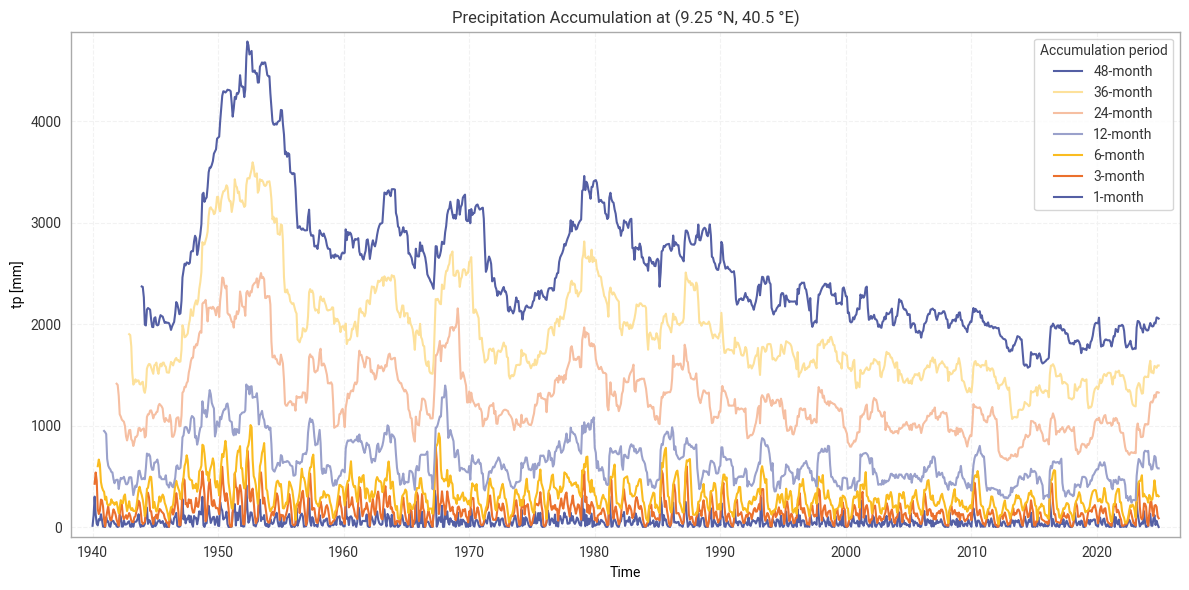

In [15]:
plot_accumulation("tp", precipitation_example_site, example_site)

#### 2. Fit gamma distribution (over calendar months) to different accumulation periods.

The gamma distribution [reference] is fitted only to the data within the reference period (1991-2020). A separate distribution is fitted for each calendar month per accumulation window. 

For e.g. : in the 3-month accumulation window, a gamma distribution is fitted on all 30 Januaries in that reference period, all the Februaries (30 of them) and so forth... 

This fitting is done with the [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) object in Python. Three parameters are then outputted per calendar month, per accumulation period: the shape ($\alpha$), location ($\beta$) and scale ($\lambda$) parameter.

In [ ]:
# Feedback: Remove testing code when done testing
# I accidentally cleared the cell output while reviewing
# Temporarily moved into separate cell for testing -- merge back into fitting cell below when done
precipitation_example_site_reference = precipitation_example_site.sel(**reference_window) # select only reference precipitation window.
precipitation_example_site_entire = precipitation_example_site.sel(**entire_window) # select only reference precipitation window.

In [17]:
# OB function testing (new)
params_fitted = fit_monthly_spi(precipitation_example_site_reference)
params_fitted 

<xarray.Dataset> Size: 2kB
Dimensions:          (month: 12, stat: 3)
Coordinates:
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    number           int64 8B ...
    latitude         float64 8B 9.25
    longitude        float64 8B 40.5
Dimensions without coordinates: stat
Data variables:
    tp_mm_accum_1m   (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_3m   (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_6m   (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_12m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_24m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_36m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_48m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

**Feedback:** Do we want to visualise the fit parameters in any way?

#### 3. Compute SPI series

From the parameters from the gamma distribution fitting, we calculate the cumulative distribution function or CDF, $F(x, \alpha, \beta, \lambda)$, up to the accumulated precipitation $x$, from the probability distribution function or PDF, $f(u, \alpha, \beta, \lambda)$:

\begin{equation}
F(x, \alpha, \beta, \lambda) = \int_{0}^{x}f(u, \alpha, \beta, \lambda) \, du.
\end{equation}

A one-to-one mapping of SPI-index to accumulated precipitation value is then obtained by transforming the cumulative probability values to a standard normal distribution with a mean ($\mu$) of zero and standard deviation ($\sigma$) of 1. This mapping is applied to the historical record of the accumulated precipitation values in that calendar month and accumulation window.

\begin{equation}
\text{SPI-index} = \Phi^{-1}\big(F(x, \alpha, \beta, \lambda)\big)
\end{equation}


In [18]:
# Compute SPI series -- new function  # Feedback: Clean up comments like this
cdf_ds, spi_ds = compute_monthly_spi(precipitation_example_site_entire, params_fitted)

#### 4. Calculating historical ratio of months without precipitation and finding zero adjusted SPI (ref dataset)
In regions of extremely low precipitation (e.g. the Sahara desert), months may have little to no accumulated precipitation. This poses a problem when fitting the gamma distribution since it is defined only for positive, real values. Furthermore, a criteria is set so that out of the 30 months in the reference period, per calendar month & accumulation window, 10 months must have non-zero accumulated precipitations. Otherwise, the calendar month is reported as having no value.

Months with zero precipitation are defined as less than 0.1 mm by the [Copernicus European (EDO) and Global (GDO) Drought Observatories](https://drought.emergency.copernicus.eu/). The ERA5-Drought dataset appears to define months with zero precipitation as having an accumulated precipitation exactly equal to zero. 

To get around some months having zero precipitation, the CDF is adjusted with the historical occurrence $p_{0}$ of periods with zero precipitation [Stagge et al., ‘Candidate Distributions for Climatological Drought Indices](https://doi.org/10.1002/joc.4267).

\begin{equation}
F_{p_{0}}(x_{p>0},  \alpha, \beta, \lambda) = p_{0} + \big(1 - p_{0}\big) \, F(x_{p>0},  \alpha, \beta, \lambda),
\end{equation}

where $F_{p_{0}}(x_{p>0},  \alpha, \beta, \lambda)$ is the CDF adjusted for zero precipitation.

**Feedback:** Can we phrase this in a way where we immediately introduce the 'correct' way? Otherwise it gets a bit confusing.  
This simple treatment can lead to a z-distribution that is skewed, with a non-zero mean. Therefore, special care must be taken, and $p_{0}$ must be adjusted for the "centre of probability mass" following:

\begin{equation}
\bar{p}_{0} = \frac{n_{p=0} + 1}{2(n + 1)},
\end{equation}

where $n_{p=0}$ are the number of calendar months in the reference period per accumulation window, and n are the total number of calendar months (30 reference calendar months).

\begin{equation}
F_{\bar{p}_{0}}(x, \alpha, \beta, \lambda) =
\begin{cases}
\bar{p}_{0} + (1 - \bar{p}_{0}) \, F(x_{p>0},  \alpha, \beta, \lambda), & x > 0, \\[6pt]
\frac{n_{p=0} + 1}{2(n+1)}, & x = 0.
\end{cases}
\end{equation}
This maintains the mean SPI value of zero, allowing for an objective statistical comparison.

In [19]:
adjusted_cdf_ds, stats_sum = zero_precip_monthly_xr(precipitation_example_site_entire, cdf_ds, reference_window)

**Feedback:** This doesn't need its own subsection
#### 5. Adjust SPI values with zero precipitation probability.

The CDF adjusted for months of zero precipitation is once again transformed to the z-normal distribution:

\begin{equation}
\text{Adjusted SPI-index} = \Phi^{-1}\big(F_{\bar{p}_{0}}(x,  \alpha, \beta, \lambda)\big)
\end{equation}

In [20]:
adjusted_spi_ds = cdf_to_spi_transform(adjusted_cdf_ds)

**Feedback:** Section numbers?
#### Importing ERA5-Drought SPI data from dataset for comparison.
Data request must be "weaved" as request too big for entire time range.

In [21]:
# Feedback: Use templates to remove redundancy (like above)
# Cleanest way to do this is probably to make one request (using template from above for year, month, etc
# and then splitting it into multiple dynamically, e.g. separating it into one request per 25 years or something
# Feedback: Make it clear to the user how they change the area, or automatically pick an area around their test site from before

drought_dataset = "derived-drought-historical-monthly"

spi_request1 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [f"{y}" for y in range(1940,1981)],
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": [9.45, 40.25, 8.95, 40.75]
}

spi_request2 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [f"{y}" for y in range(1981,2025)],
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": [9.45, 40.25, 8.95, 40.75] # Ethiopia
}

era5_drought_spi = ekd.from_source("cds", drought_dataset, spi_request1, spi_request2) # Sends request for this dataset to CDS.
era5_drought_spi = era5_drought_spi.to_xarray(compat="equals") # Converts to xarray.
era5_drought_spi = era5_drought_spi.sel(lat=9.25,lon=40.5, method="nearest")

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.19it/s]
/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  return xr.open_mfdataset(


#### Comparison of the calculated SPI-index vs ERA5-Drought SPI-index (qualatitive & quantative)
Now that we have calculated the SPI-index for one grid point, for all accumulation windows, we make a qualatitive and quantitative comparison with the corresponding data in the ERA5-Drought dataset. 

First, we plot the timeseries of the SPI drought index, calculated and from the derived dataset on the same plot for a qualatitive comparison.

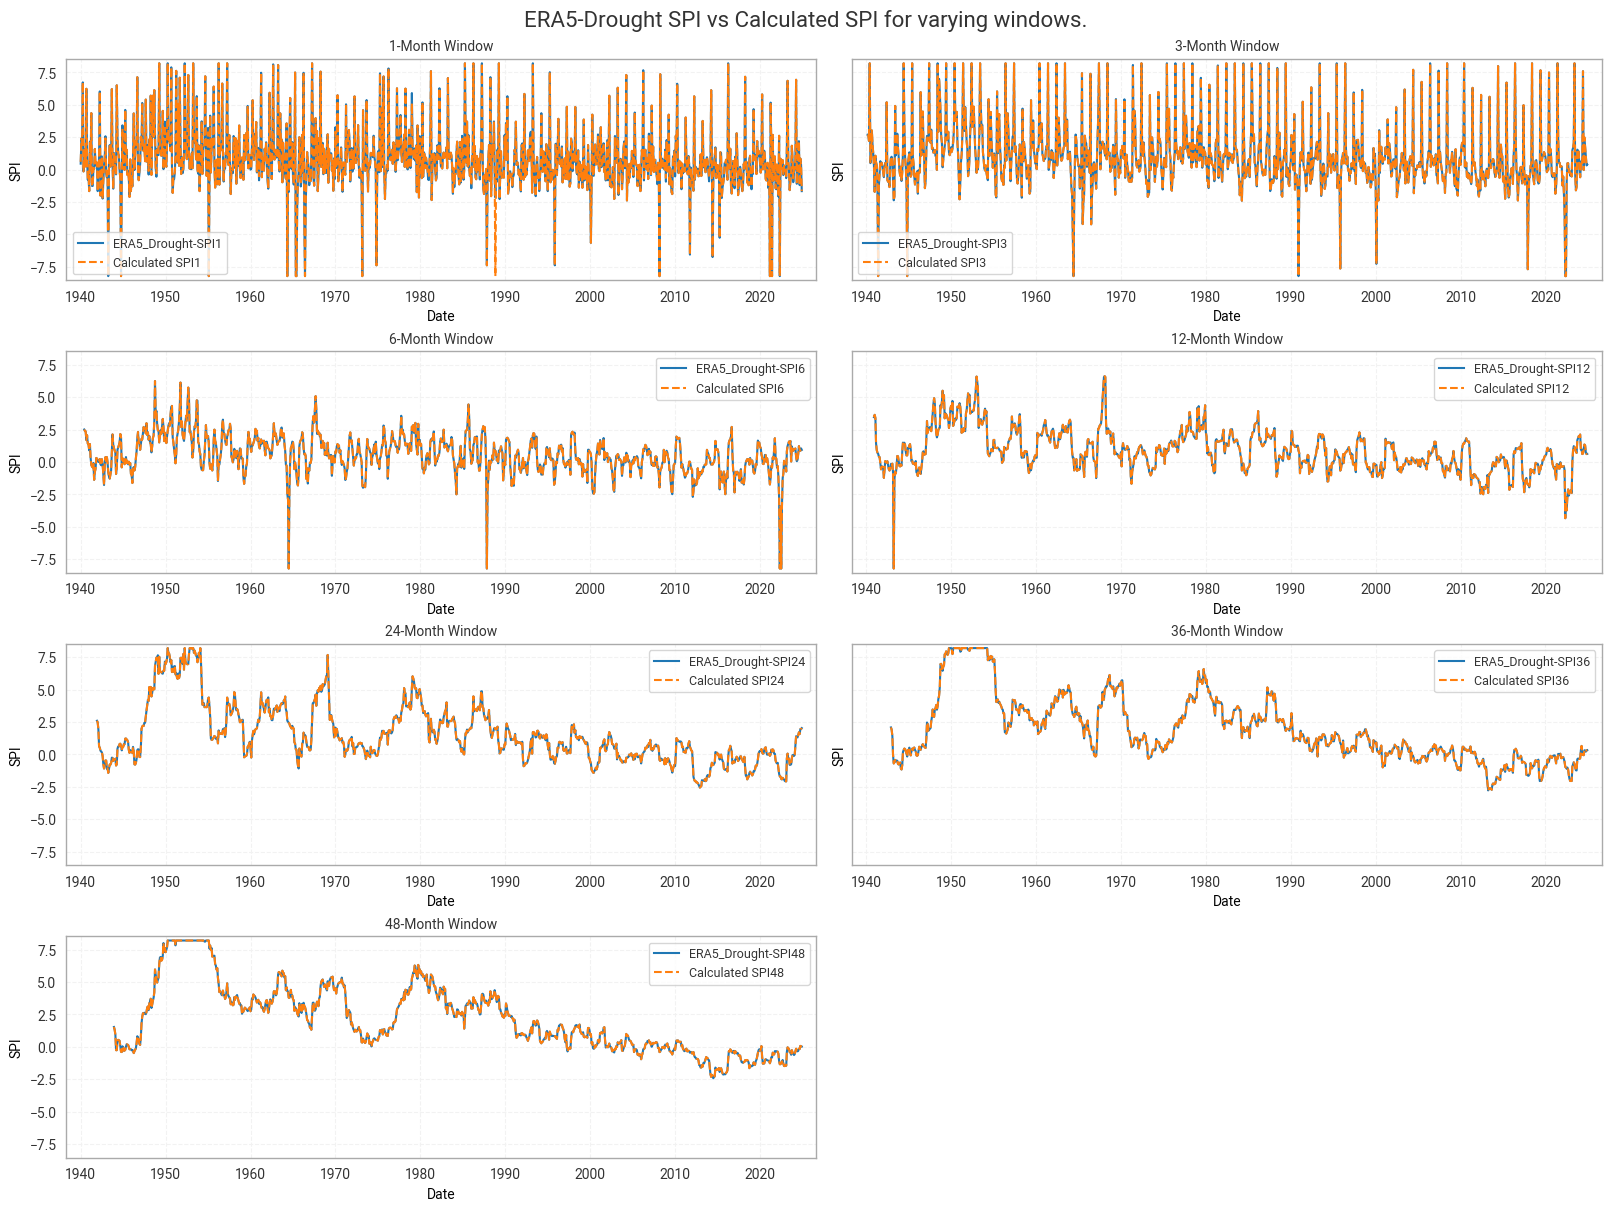

In [45]:
plot_qual_index_comparison("SPI", era5_drought_spi, adjusted_spi_ds)

**Feedback:** Would it be clearer to have this in the same figure as the absolute comparison?  
Then we plot the time series of the residual, i.e. the difference at each timestamp along with the Mean Difference and Mean Absolute Difference for each accumulation window.

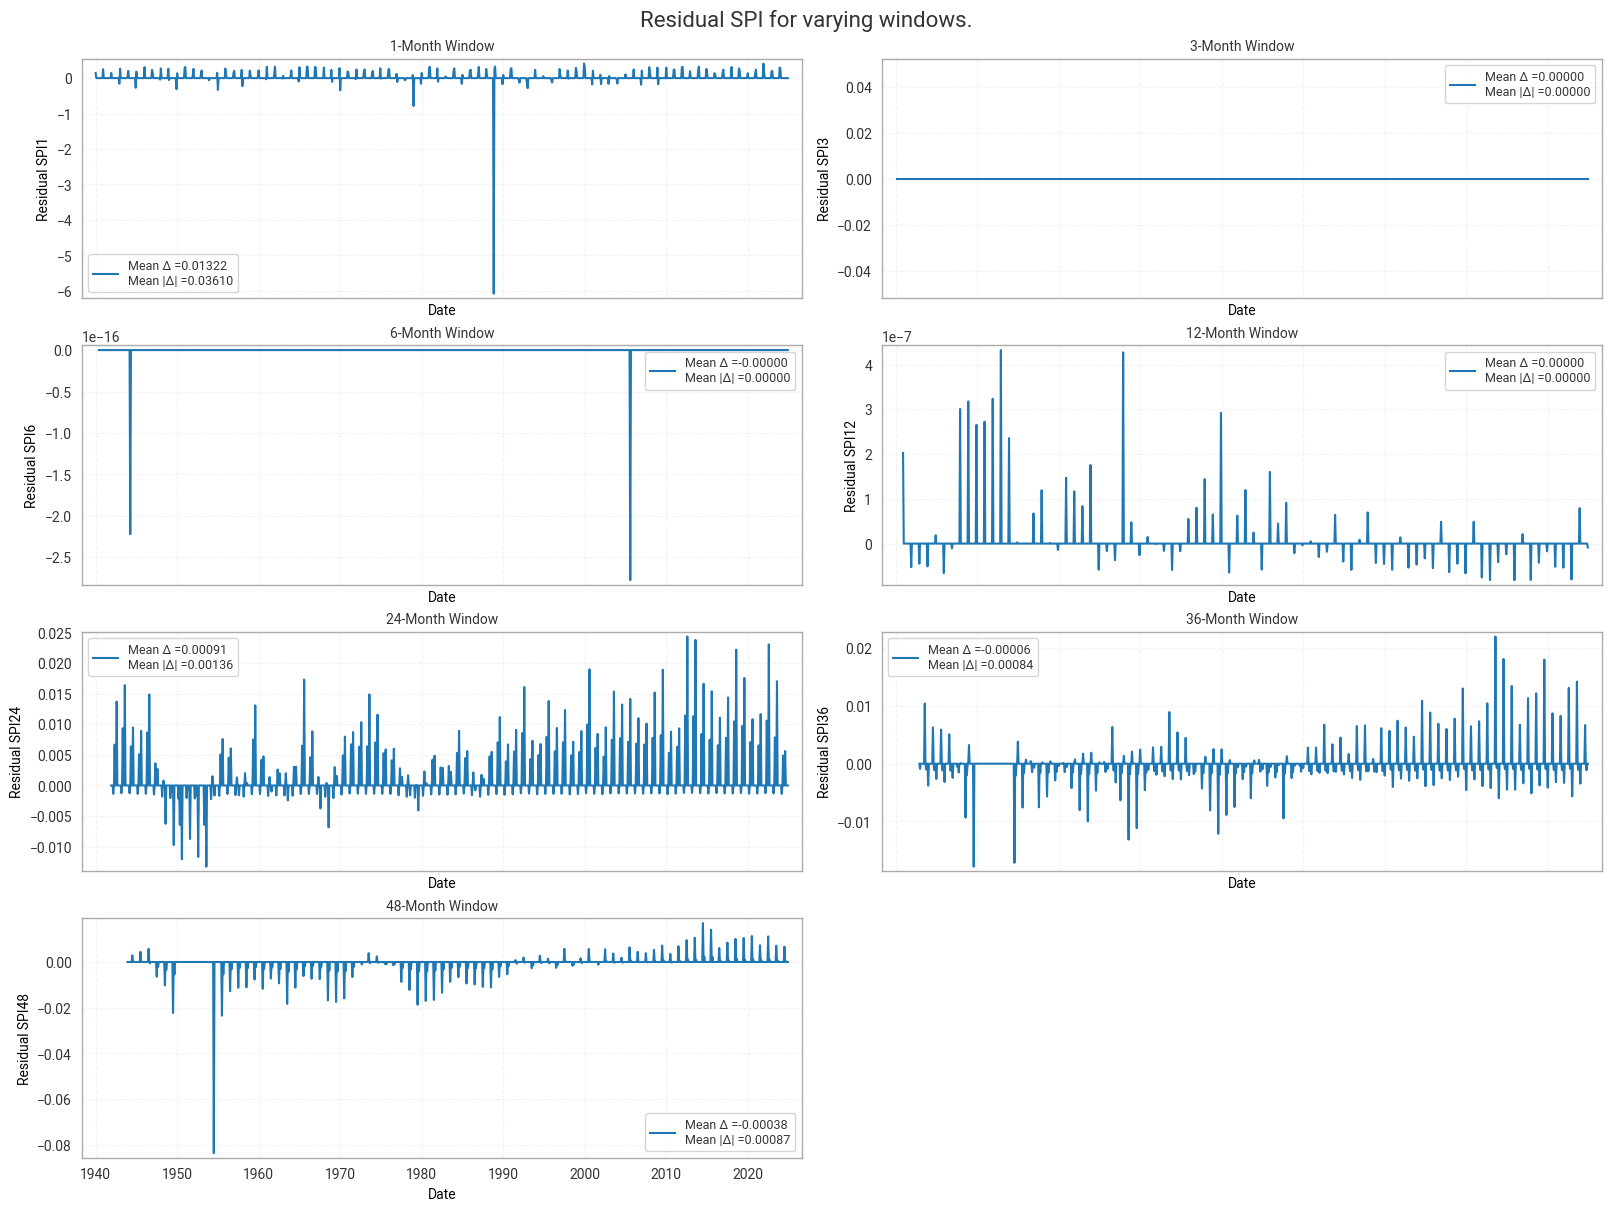

In [46]:
plot_residual_index_comparison("SPI", era5_drought_spi, adjusted_spi_ds)

**Feedback:** Why not do all accumulation windows?  
Use consistent bins etc

Lastly, we make plot a frequency histogram of the residuals for a certain accumulation window (here 48), for each month

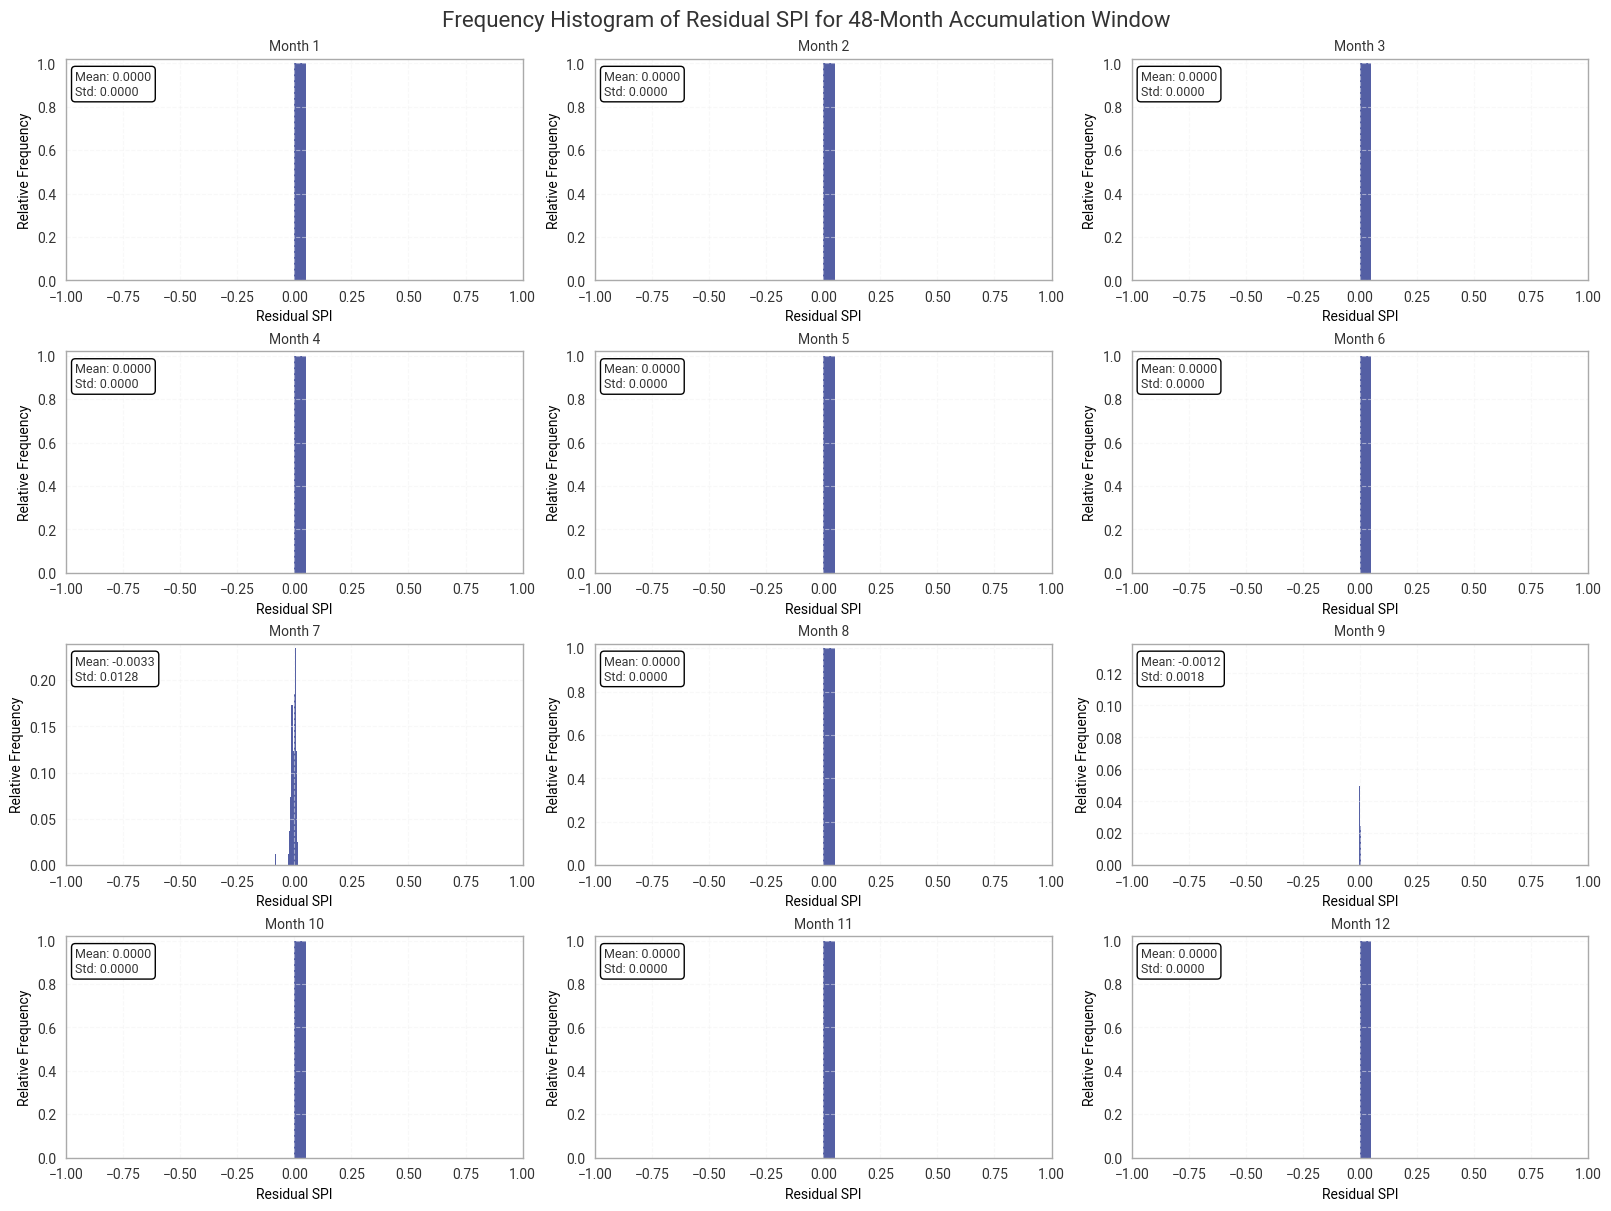

In [22]:
plot_histogram_index_comparison("SPI", era5_drought_spi, adjusted_spi_ds, "48")

####  6. Comparison of "Probability of Zero Precipitation"
You can also import the "probability of zero precipitation" for a given calendar month, in the reference period, per accumulation period instead of calculating it as we have done. 

**Feedback:** Remove value judgements like "improper formatting"  
Due to improper formatting from ERA5-Drought, you are unable to send an API request to download the data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period (in this case, the 48-month window). 

**Feedback:** My preferred approach here would be to keep the request setup the same for transparency, and only modify those bits that change.  
E.g. download data in a dict-comp with `ekd.from_source` visible to the user,
then use a function to rename and merge.  
We have written a simple helper function, "era5_api_multiple" that sends separate API requests, concatenating the data into a single xarray, to then use.

In [23]:
prob_spi_zero_all = era5_drought_api_multiple(indicator = "spi", var = "prob_zero")
prob_spi_zero_all_ds = prob_spi_zero_all.sel(lat=9.25,lon=40.5, method="nearest")

In [24]:
for p in ACCUMULATION_PERIODS:
    diff = prob_spi_zero_all_ds[f"prob_zero_{p}"].groupby("time.month")- stats_sum["Prob Zero Precip"].sel(accumulation_period=p)
    # Check if any non-zero values exist
    if (diff != 0).any():
        print(f"Mismatch at Accumulation Period {p} of:")
        print(diff.values)  # Print the actual values

Mismatch at Accumulation Period 1 of:
[0.01612903 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01612903]


#### 7. Comparison of quality indicator.

Quality control is performed by the ERA5-Drought team over the entire dataset. This is done by testing if the calculated distribution of the estimated drought indices over the reference period follows a normal distribution with mean 0 and standard deviation 1. 

This test is performed using the Shapiro-Wilks test for normality [S. S. SHAPIRO, M. B. WILK, An analysis of variance test for normality (complete samples), Biometrika, Volume 52, Issue 3-4, December 1965, Pages 591–611](https://doi.org/10.1093/biomet/52.3-4.591), with a $\alpha$ = 0.05 on the data in the reference period (1991-2020). 

If the resultant p-value is less than $\alpha$ = 0.05, the corresponding quality parameter is set to 0 (bad), otherwise set to 1 (good).

##### We perform this test over the calculated SPI values, that are adjusted for zero-precipitation. 

In [25]:
stat, pval, sig = xr_shapiro_test(adjusted_spi_ds)

##### Importing Shapiro-Wilks SPI Significance Test results from ERA5-Drought dataset.
You can also import the quality flags from ERA5-Drought, for every calendar month, in the reference period, per accumulation period. 

Due to improper formatting from ERA5-Drought, you are unable to send an API request to download this data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period (in this case, the 48-month window). 

We have written a simple script that sends separate API requests, concatenating the data into a single xarray, to then use.

In [26]:
quality_spi_all = era5_drought_api_multiple(indicator = "spi", var = "quality")
quality_spi_all = quality_spi_all.sel(lat=9.25, lon = 40.5)

##### Comparison of significance values

In [27]:
sig_diff = quality_spi_all.groupby('time.month') - sig
cond =  (sig_diff != 0).compute()
# Does cond have any True anywhere?
any_true = cond.any().compute()   # -> bool

if not any_true:
    print("Values from ERA5 Significance match calculated significance values.")

Values from ERA5 Significance match calculated significance values.


#### 8. Calculating ERA5-Drought SPI (across a region)
Repeat calculations here but very quickly (i.e. just follow the steps from before but without all the steps and plots in between)
All functions should be written so that they can take data with only one (lat, lon) point as before or the entire dataset at once

**Feedback:** Test if it's possible to just run the entire calculation over the entire domain straight away and only plot intermediate steps for one location (hoping that dask means it only calculates in those pixels that are displayed), rather than doing the calculation for one location and then doing it again for everything.

**Feedback:** Can we do a bigger region? In any case it should be consistent with the previous example, that single pixel should fall within this region.

##### Accumulate precipitations

In [28]:
acc_periods = [48]

# Select latitude and longitude box (keeping small for smaller compute time, recommended 10 x 10)
lon_min, lon_max = 19.0, 21.5   
lat_min, lat_max = 41.0, 43.5

# Subset (latitude is descending in ERA5)
ds_loc = era5_monthly_mean_reanal.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
)

ds_loc = accum_var(ds_loc, var = "tp")

precipitation_example_site_reference = ds_loc.sel(**reference_window) # select only reference precipitation window.

##### Fit gamma distribution onto site.

In [29]:
params_fitted = fit_monthly_spi(precipitation_example_site_reference)

##### Calculate SPI over region.

In [30]:
precipitation_example_site_entire = ds_loc.sel(**entire_window) # select only reference precipitation window.
cdf_ds, spi_ds = compute_monthly_spi(precipitation_example_site_entire, params_fitted)

##### Adjust for zero precipitation

In [31]:
adjusted_cdf_ds, stats_sum = zero_precip_monthly_xr(precipitation_example_site_entire, cdf_ds, reference_window) # takes a while

In [32]:
adjusted_spi_ds = cdf_to_spi_transform(adjusted_cdf_ds)

##### Download 48-month accumulation period over region.

In [33]:
dataset = "derived-drought-historical-monthly"

request1 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [f"{y}" for y in range(1940,1981)],
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": [43.5, 19.0, 41.0, 21.5]  # lat, lon 
}

request2 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [f"{y}" for y in range(1981,2025)],
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": [43.5, 19.0, 41.0, 21.5] # lat, lon 
}

era5_spi = ekd.from_source("cds", dataset, request1,request2) # Sends request for this dataset to CDS.
era5_spi = era5_spi.to_xarray(compat="equals") # Converts to xarray.

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 99.88it/s]


##### Calculate difference

In [34]:
adjusted_spi_ds = adjusted_spi_ds.rename({
    "valid_time": "time",
    "latitude": "lat",
    "longitude": "lon"})

In [35]:
era5_spi, adjusted_spi_ds = xr.align(era5_spi, adjusted_spi_ds, join="left")   # only overlapping coords
# spi_diff_mean = spi_diff.mean(dim="time")

In [36]:
spi_diff_mean = abs(adjusted_spi_ds["SPI48"]-era5_spi["SPI48"]).mean("time")

In [43]:
spi_diff = abs(adjusted_spi_ds["SPI48"]-era5_spi["SPI48"]).sel(time = "2024-12-01")

##### Plot spatial difference

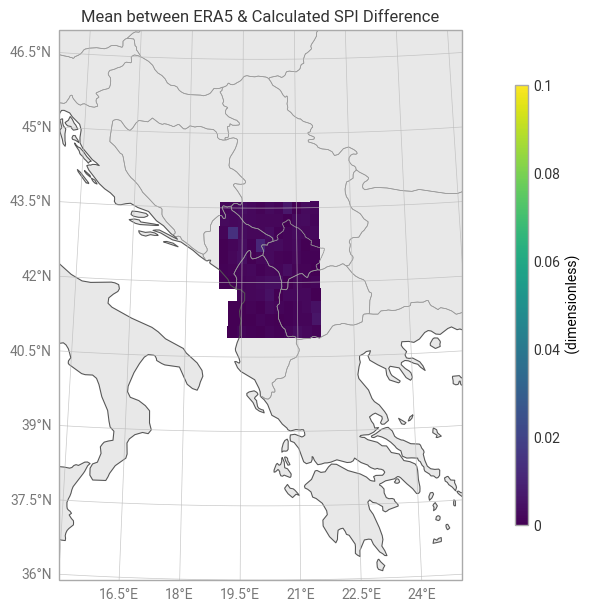

In [59]:
# Select one time slice and one ensemble
from earthkit.plots.styles import Style
from earthkit.plots.geo import domains

global_mean_map = spi_diff_mean

balkans = domains.Domain.from_bbox(
    bbox=[15, 25, 36, 47],
    name="Balkans",
)
# Convert to NumPy arrays

mean_values = global_mean_map.to_numpy()
lat_values = global_mean_map.lat.to_numpy()
lon_values = global_mean_map.lon.to_numpy()
 
# Create meshgrid

lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
 
# # Plot with EarthKit

SPI_STYLE = Style(cmap='viridis', vmin = 0, vmax = 0.1, normalize=False)

# Create figure with 2 columns
fig = ekp.Figure(rows=1, columns=1, size=(12, 6))  

# First subplot (left)
subplot = fig.add_map(domain=balkans, row=0, column=0)
subplot.grid_cells(mean_values, x=lon_grid, y=lat_grid,style=SPI_STYLE)
subplot.legend(location="right")
subplot.title("Mean between ERA5 & Calculated SPI Difference")

# Add decorations
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()
fig.show()

(section-3)=
###  3. Calculating ERA5-Drought SPEI from reanalysis data.
The steps to calculating the SPEI-index are exactly the same as calculating the SPI index, with the only modification being that the SPEI integrates both the precipitation and potential evapotranspiration (PET) data. 

#### Importing monthly-average potential evaporation data.

We import the monthly-mean potential evaporation data from the "ERA5 monthly-averaged data on single levels from 1940 to present" dataset.(https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

In [39]:
request_era5_pev_moda = {
    "param": "251.228",       # Variable: Potential evaporation (pev)
    "stream": "moda",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [40]:
# Download data and convert to desired format
era5_monthly_mean_pev_reanal = ekd.from_source("cds", ID_ERA5, request_era5_pev_moda)  # Download as field list
era5_monthly_mean_pev_reanal = era5_monthly_mean_pev_reanal.to_xarray(compat="equals")  # Convert to xarray dataset
era5_monthly_mean_pev_reanal = rechunk(era5_monthly_mean_pev_reanal)  # Re-chunk for speed gain in fitting
era5_monthly_mean_pev_reanal  # Display in notebook

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 1020, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    pev         (valid_time, latitude, longitude) float32 4GB dask.array<chunksize=(1020, 103, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### 1. Calculate moving average for different accumulation periods (PET/PEV & TP).

A time series of both precipitation & potential evaporation (PET/PEV) from one grid point are extracted and the precipitation & potential evaporation are accumulated over the previous $n$ months using a moving window, analogous to the SPI.

Note, [ECMWF convention](https://codes.ecmwf.int/grib/param-db/182) is that negative values for PEV/PET indicate evaporation, whereas positive values indicate condensation.

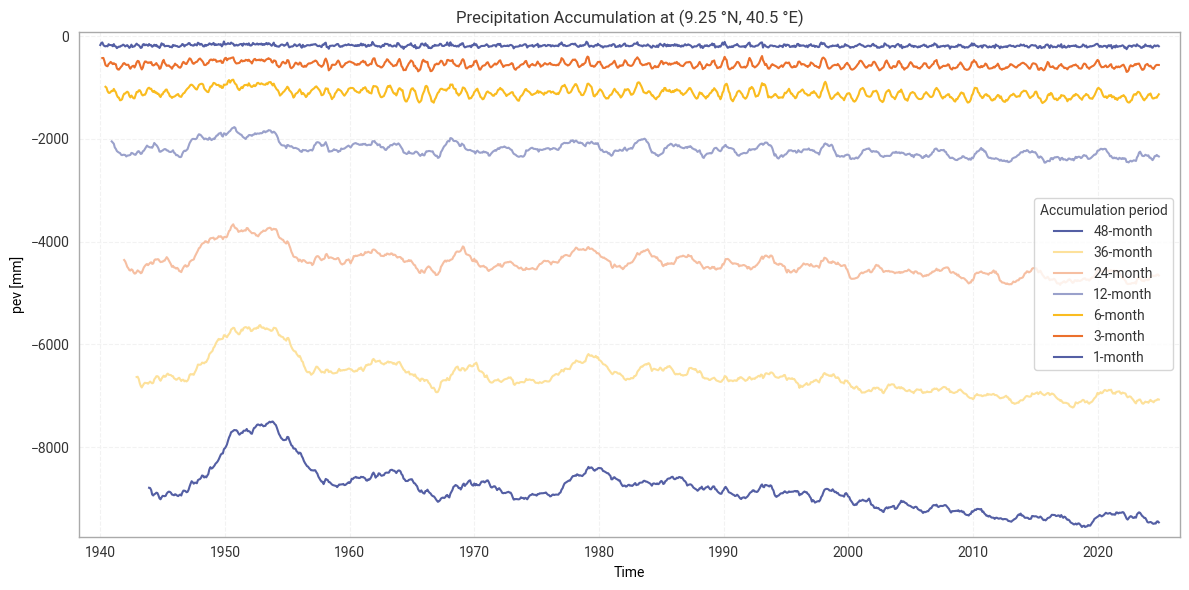

In [50]:
# Select the grid point and time slice for Ethiopia
pev_example_site = era5_monthly_mean_pev_reanal.sel(**example_site)

# Perform the accumulation for each accumulation period
pev_example_site = accum_var(pev_example_site, "pev")

plot_accumulation("pev", pev_example_site, example_site)

In [42]:
wb_ds = xr.Dataset(
    {
        f"wb_{var.replace('tp_', '')}": precipitation_example_site[var]
                                       + pev_example_site[var.replace("tp_", "pev_")]
        for var in precipitation_example_site.data_vars # loop through every variable.
        if var.startswith("tp_") and var.replace("tp_", "pev_") in pev_example_site.data_vars
    }
)

#### Plot of the accumulated water balance (P-PET).
Since the ECMWF convention is that a negative value of PET indicates evaporation, care must be taken when subtracting the precipitation (P) by the potential evaporation (PEV/PET).

The negative of PEV/PET must be applied, $P − (−PET) = P + PET$ in this case. 

This approach aligns with the definition of the water balance, where a negative water balance value indicates that more water is potentially being transferred to the atmosphere. 

It also makes sense when interpreting the accumulated plots of both potential evaporation and water balance in a country like Ethiopia (below), where one might expect more evaporation and in fact has a negative water balance (as is the case).



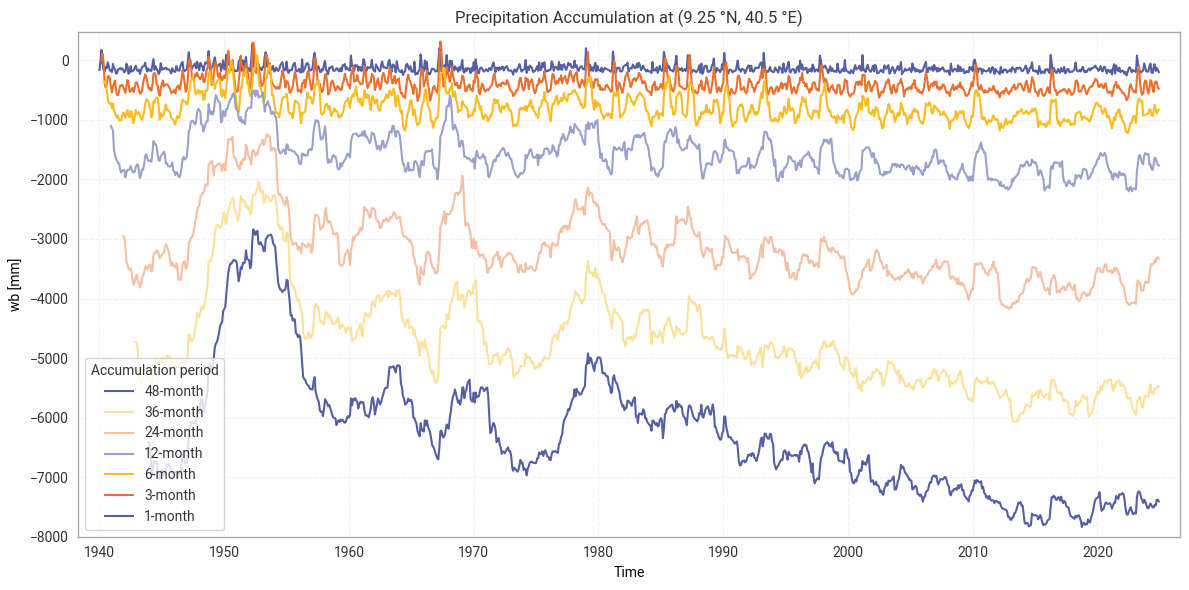

In [51]:
plot_accumulation("wb", wb_ds, example_site)

#### 2. Fit Generalised Log-Logistic Distribution to PET.

The general log-logistic distribution [reference] is fitted only to the data within the reference period (1991-2020), similar to the gamma distribution being fitted in the calculation of the SPI-index. A separate distribution is fitted for each calendar month per accumulation window.

This fitting is done with the [scipy.stats.genlogistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genlogistic.html) object in Python. Three parameters are then outputted per calendar month, per accumulation period: the shape (), location () and scale () parameter.

In [52]:
# Fit log logistic distributions
log_params_fitted = fit_monthly_spei(wb_ds.sel(**reference_window))

#### 3. Compute SPEI series.

Similar to the calculation for the SPI index, the three parameters from the fitted general log-logistic distribution are taken and the cumulative distribution function (CDF) is calculated up to the accumulated water balance, from the probability distribution function (PDF).

As $ P − PET $ is barely identical to 0, no modifications analogous to the SPI such as adjusting for zero precipitation, are required.

In [53]:
params_fitted = log_params_fitted.rename({v: v.replace("tp_", "wb_")
                                          for v in log_params_fitted.data_vars})

In [54]:
# Compute SPI series
cdf_spei_ds, spei_ds = compute_monthly_spei(wb_ds, params_fitted)

#### 4. Quality control using the Shapiro-Wilks test on calculated SPEI data.

Shapiro-Wilks test is performed on the calculated SPEI index below.

In [55]:
stat, pval, sig = xr_shapiro_test(spei_ds.sel(**reference_window))

Quality flags are imported from ERA5-Drought, for every calendar month, in the reference period, per accumulation period for the SPEI index.

Due to improper formatting from ERA5-Drought, you are unable to send an API request to download this data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period (in this case, the 48-month window). 

We have written a simple script that sends separate API requests, concatenating the data into a single xarray, to then use.

In [56]:
quality_spei_all = era5_drought_api_multiple(indicator = "spei", var = "quality")

The calculated Shapiro-Wilks significance values are then compared with those from ERA5. Any discrepancy is flagged with a simple print statement.

In [57]:
# select quality flags at one location and compare that with dataset.
quality_spei_all_ds = quality_spei_all.sel(lat=9.25,lon=40.5, method="nearest")

sig_diff = quality_spei_all_ds.groupby('time.month') - sig
cond =  (sig_diff != 0).compute()
# Does cond have any True anywhere?
any_true = cond.any().compute()   # -> bool

if not any_true:
    print("Values from ERA5 Significance match calculated significance values.")
else:
    print("Values from ERA5 Significance do not match calculated significance values.")

Values from ERA5 Significance match calculated significance values.


#### Comparison of the calculated SPEI-index vs ERA5-Drought SPEI-index (qualatitive & quantative)

In [60]:
dataset = "derived-drought-historical-monthly"
request1 = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [f"{y}" for y in range(1940,1982)],
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": [9.45, 40.25, 8.95, 40.75]
}

request2 = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [f"{y}" for y in range(1982,2025)],
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": [9.45, 40.25, 8.95, 40.75]
}

data_spei = ekd.from_source("cds", dataset, request1,request2) # Sends request for this dataset to CDS.
data_spei = data_spei.to_xarray(compat="equals") # Converts to xarray.
data_spei = data_spei.sel(lat=9.25,lon=40.5, method="nearest")

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 339.47it/s]
/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  return xr.open_mfdataset(


We plot a timeseries of the SPEI drought index, calculated from the derived dataset on the same plot for a qualatitive comparison.

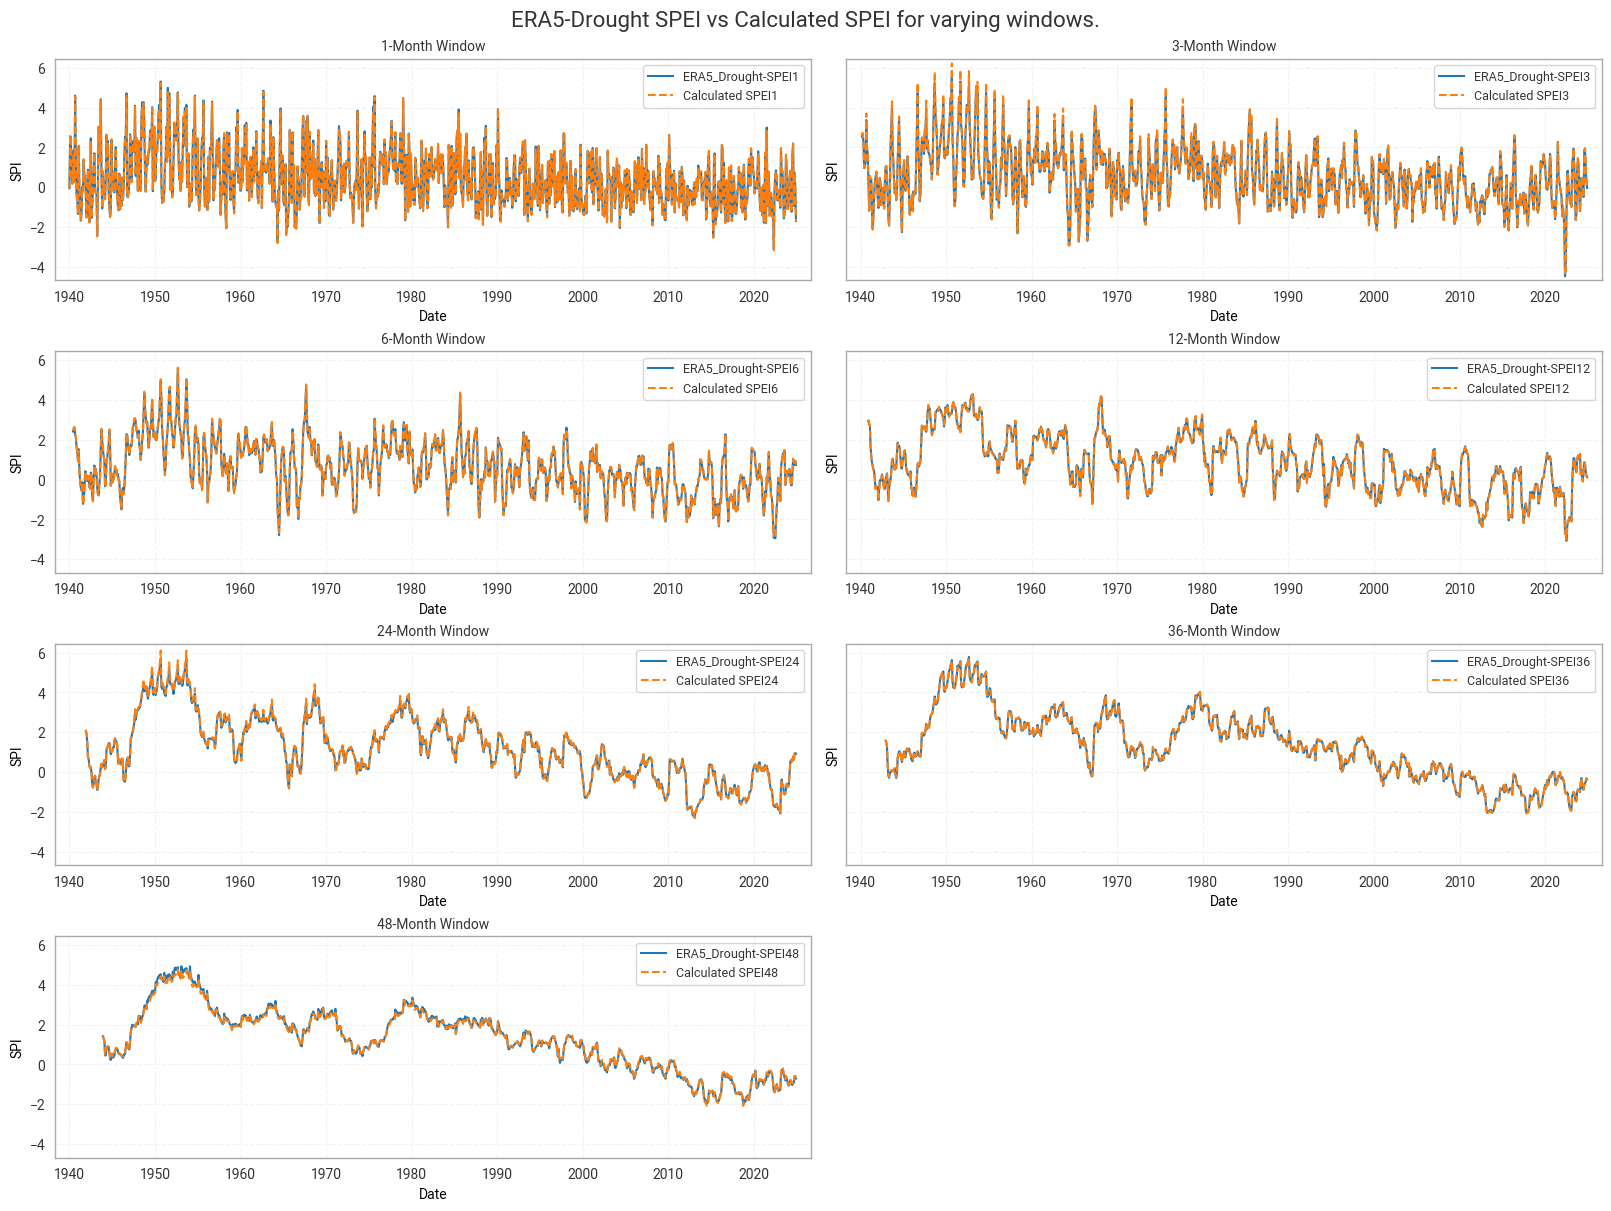

In [61]:
plot_qual_index_comparison("SPEI", data_spei, spei_ds)

As before, we then plot the timeseries of the residual between the calculate SPEI drought index and from the derived datasetfor a quantatitive comparison.

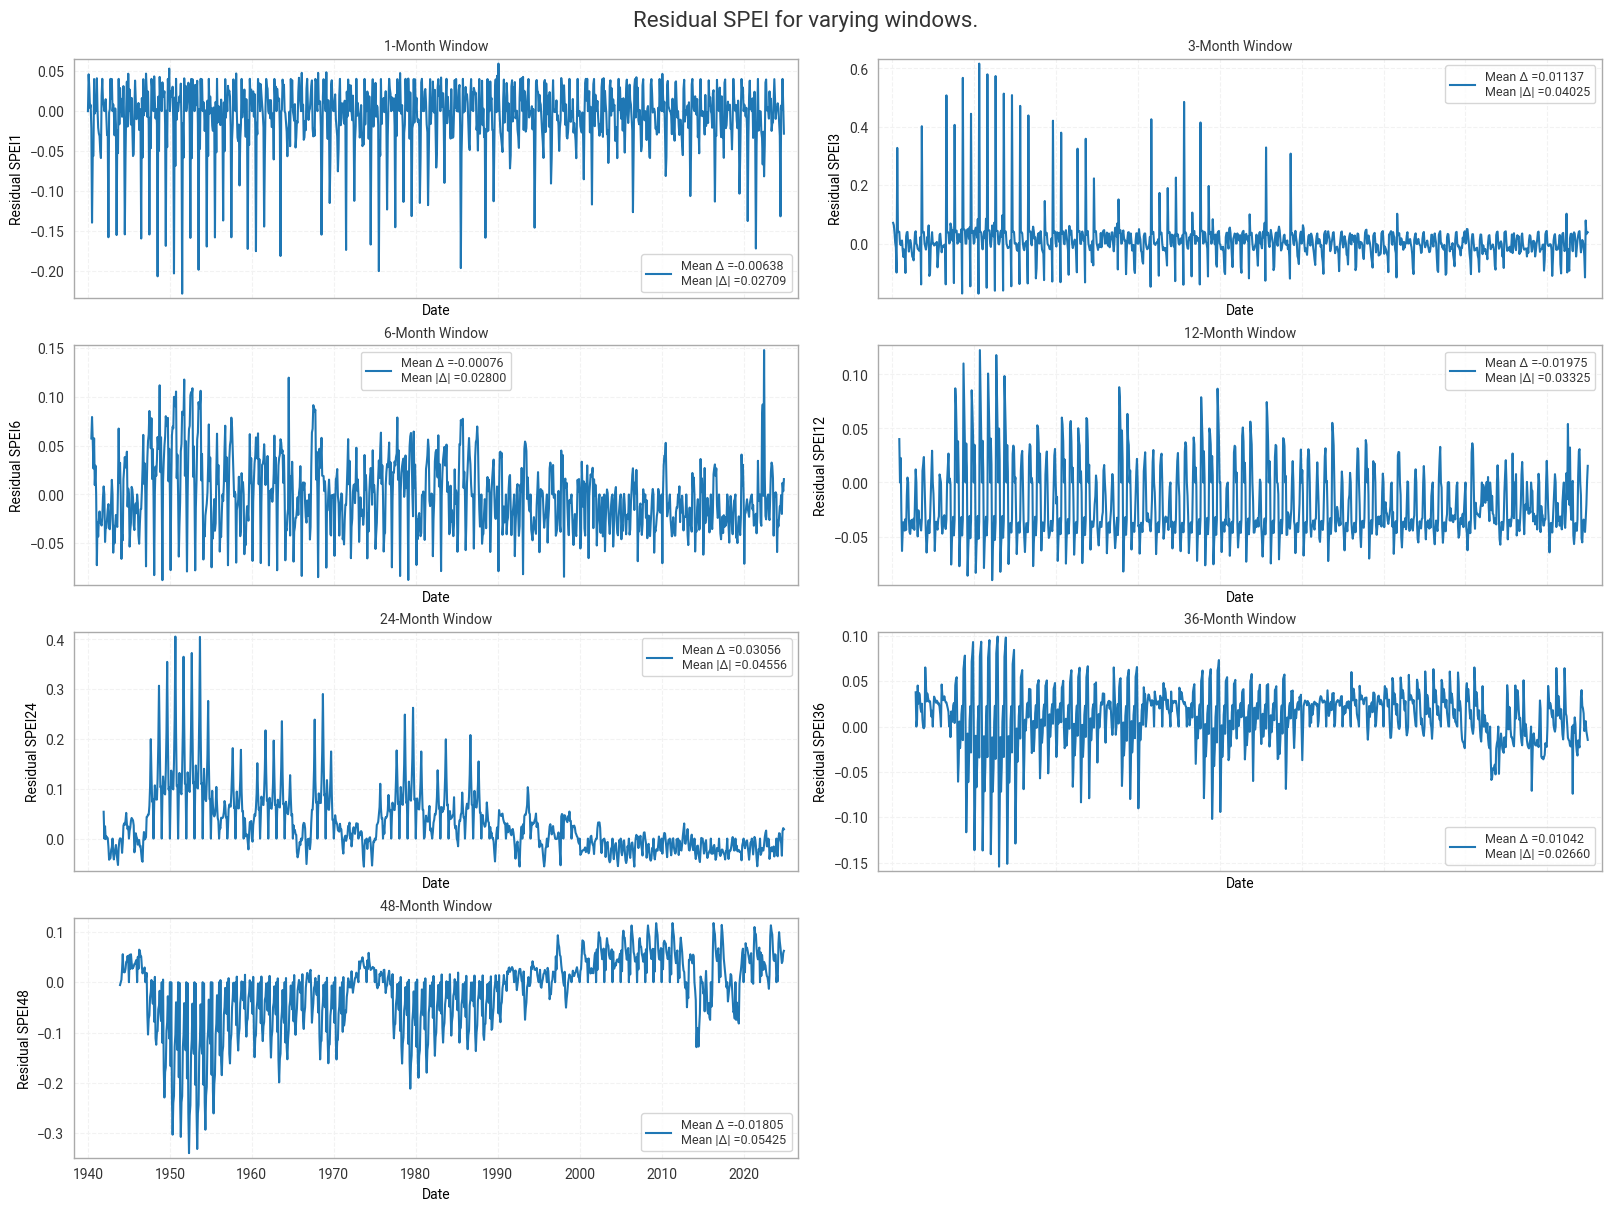

In [62]:
plot_residual_index_comparison("SPEI", data_spei, spei_ds)

Lastly, we make plot a frequency histogram of the residuals for a certain accumulation window (e.g. 48), for each month.

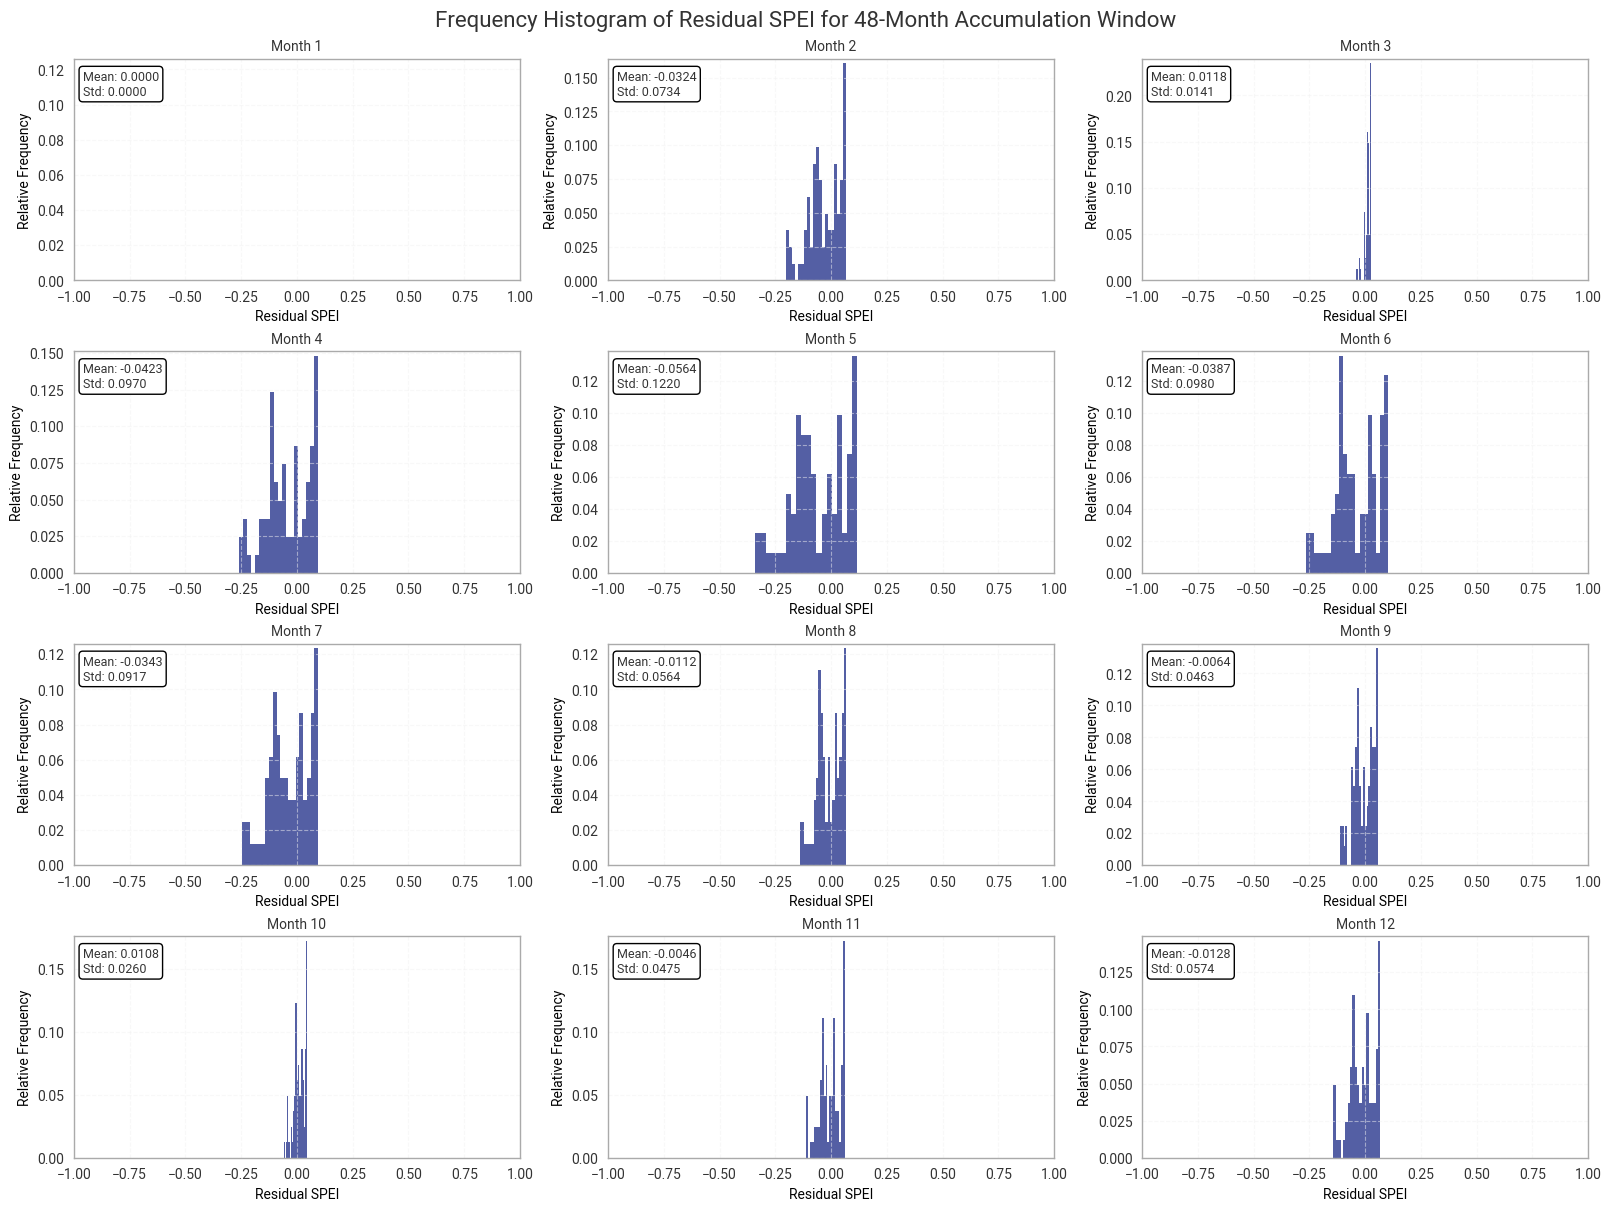

In [63]:
plot_histogram_index_comparison("SPEI", data_spei, spei_ds, window = "48")

#### Comparison of the calculated SPEI-index vs ERA5-Drought SPEI-index with quality flags (quantatitive)

In [66]:
accum_periods = [1, 3, 6, 12, 24, 36, 48]

for period in accum_periods:
    drought_spi = data_spei[f"SPEI{period}"].copy()
    calc_spi = spei_ds[f"SPEI{period}"].copy() # copy so it doesn't change.
    
    for month in range(1,13):        
        significance = quality_spei_all_ds[f"significance_{period}"].sel(time=f"2020-{month:02d}-01").compute().item()
        if significance == 0:
            drought_spi = drought_spi.where(drought_spi.time.dt.month != month, other=np.nan) # keeps EVERY other month- the selected one becomes nan. 
            calc_spi = calc_spi.where(calc_spi.valid_time.dt.month != month, other=np.nan)
        else:
            pass 
    
    data_spei[f"SPEI{period}"] = drought_spi # bring it back.
    spei_ds[f"SPEI{period}"] = calc_spi
    

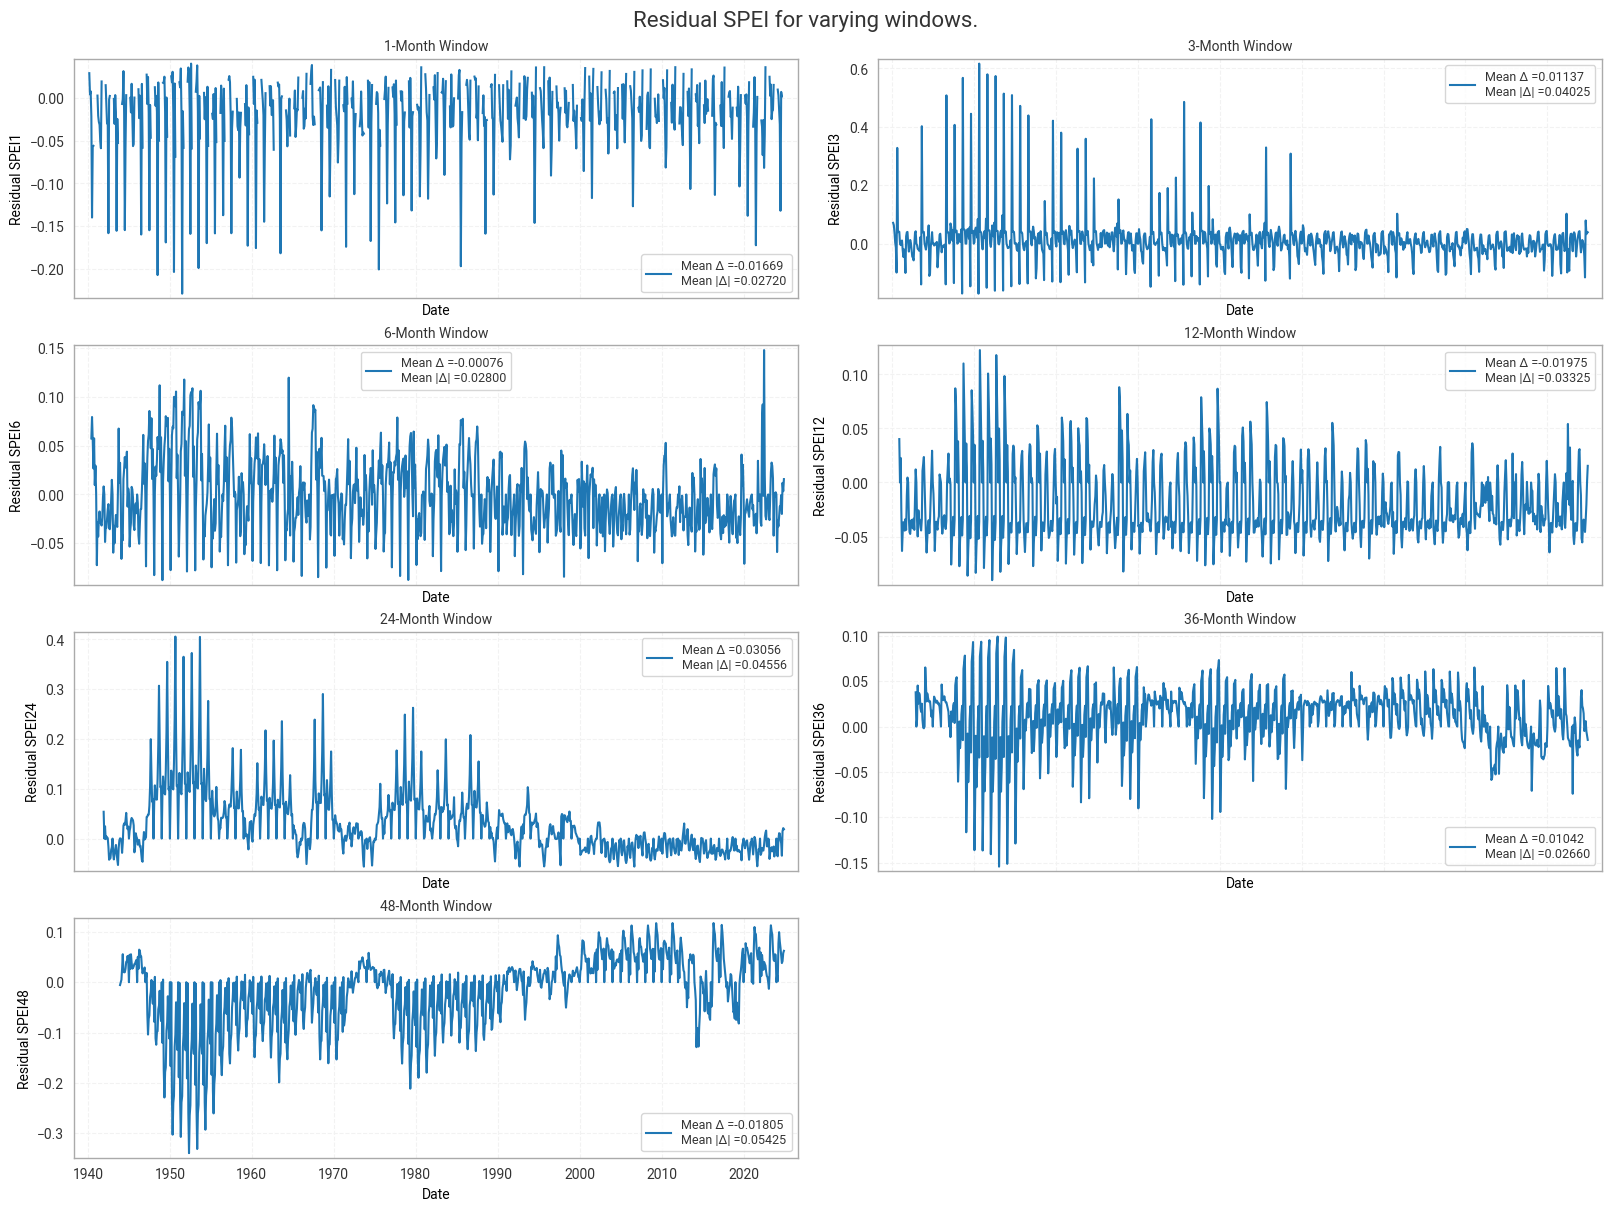

In [67]:
plot_residual_index_comparison("SPEI", data_spei, spei_ds)

(section-4)=
### 4. Calculating the SPI/SPEI Ensemble Data
Once again, calculating the SPI-index for all 10 ensemble members are the same as calculating the SPI index for one member, with the only modification being that there is an extra coordinate, "number" that identifies each ensemble member. 

**Feedback:** As before, if you're going through all the steps much faster because it's a re-hash, you don't need to include all the headers etc. – they make it harder to read if they're too densely packed

#### Download monthly ensemble precipitation data 
First, we download the monthly-mean total precipitation data from the ERA5 reanalysis, as before.

**Feedback:** If we are re-using the same template etc. but assuming the user has not run the previous sections (e.g. they restart their kernel for every section), the template should be defined outside the sections, e.g. in a general setup section above "2. Calculate SPI at one location from ERA5 reanalysis data"

In [68]:
ID_ERA5 = "reanalysis-era5-complete"

request_era5_template = {
    "class": "ea",            # Default for ERA5
    # Dates: ERA5 takes these in the format 19400101/19400201/.../20241101/20241201
    # The following line generates a string in said format from the chosen year range
    "date": "/".join(f"{year}{month:02}01"
            for year in range(years[0] ,years[1]+1)
            for month in MONTHS),
    "expver": "1",            # ERA5 consolidated data
    "levtype": "sfc",         # Surface
    "grid": "0.25/0.25",      # Grid: 0.25° by 0.25°
    "type": "fc",             # Forecast
    "data_format": "netcdf",  # NetCDF data
}

In [69]:
request_era5_precipitation_edmo = {
    "param": "228.128",       # Variable: Total precipitation
    "stream": "edmo",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [70]:
# Download data and convert to desired format
era5_monthly_mean_ens = ekd.from_source("cds", ID_ERA5, request_era5_precipitation_edmo)  # Download as field list
era5_monthly_mean_ens = era5_monthly_mean_ens.to_xarray(compat="equals")  # Convert to xarray dataset
era5_tp_monthly_mean_ens = rechunk(era5_monthly_mean_ens)  # Re-chunk for speed gain in fitting
era5_tp_monthly_mean_ens  # Display in notebook

<xarray.Dataset> Size: 42GB
Dimensions:     (number: 10, valid_time: 1020, latitude: 721, longitude: 1440)
Coordinates:
  * number      (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp          (number, valid_time, latitude, longitude) float32 42GB dask.array<chunksize=(1, 1020, 103, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### Download monthly ensemble potential evaporation data 
Next, we download the monthly-mean total potential evaporation data from the ERA5 reanalysis.

In [71]:
request_era5_pev_edmo = {
    "param": "251.228",       # Variable: Potential evaporation (pev)
    "stream": "edmo",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [72]:
# Download data and convert to desired format
era5_pev_monthly_mean_ens = ekd.from_source("cds", ID_ERA5, request_era5_pev_edmo)  # Download as field list
era5_pev_monthly_mean_ens = era5_pev_monthly_mean_ens.to_xarray(compat="equals")  # Convert to xarray dataset
era5_pev_monthly_mean_ens = rechunk(era5_pev_monthly_mean_ens)  # Re-chunk for speed gain in fitting
era5_pev_monthly_mean_ens  # Display in notebook

<xarray.Dataset> Size: 42GB
Dimensions:     (number: 10, valid_time: 1020, latitude: 721, longitude: 1440)
Coordinates:
  * number      (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    pev         (number, valid_time, latitude, longitude) float32 42GB dask.array<chunksize=(1, 1020, 103, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

**Feedback:** Only display outputs here if they are actually novel, e.g. show the xarray Dataset once to explain how the `number` dimension works, but there is no point in showing it every time.

#### Accumulate precipitation.
Precipitation is accumulated for all the accumulation periods in ERA5.

In [73]:
example_site = {"latitude": 9.25, "longitude": 40.5,}

In [74]:
# Select the grid point and time slice for Ethiopia
precipitation_example_site = era5_tp_monthly_mean_ens.sel(**example_site)

# Perform the accumulation for each accumulation period
precipitation_ens_example_site = accum_var(precipitation_example_site, "tp")

# Display result
precipitation_ens_example_site

<xarray.Dataset> Size: 596kB
Dimensions:          (number: 10, valid_time: 1020)
Coordinates:
  * number           (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * valid_time       (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... ...
    latitude         float64 8B 9.25
    longitude        float64 8B 40.5
    expver           (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp_mm_accum_1m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    tp_mm_accum_3m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    tp_mm_accum_6m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    tp_mm_accum_12m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    tp_mm_accum_24m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    tp_mm_accum_36m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    tp_mm_accum_48m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### Accumulate potential evaporation.
As is potential evaporaiton, for all the accumulation periods in ERA5.

In [75]:
# Select the grid point and time slice for Ethiopia
pev_example_site = era5_pev_monthly_mean_ens.sel(**example_site)

# Perform the accumulation for each accumulation period
pev_ens_example_site = accum_var(pev_example_site, "pev")

# Display result
pev_ens_example_site

<xarray.Dataset> Size: 596kB
Dimensions:           (number: 10, valid_time: 1020)
Coordinates:
  * number            (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * valid_time        (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ......
    latitude          float64 8B 9.25
    longitude         float64 8B 40.5
    expver            (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    pev_mm_accum_1m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    pev_mm_accum_3m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    pev_mm_accum_6m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    pev_mm_accum_12m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    pev_mm_accum_24m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    pev_mm_accum_36m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    pev_mm_accum_48m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### Calculate the water balance (P - PET).
The "water balance" is calculated, ensuring once again the -ve of the PET, as discussed earlier.  

In [76]:
wb_ens_example_site = xr.Dataset(
    {
        f"wb_{var.replace('tp_', '')}": precipitation_ens_example_site[var]
                                       + pev_ens_example_site[var.replace("tp_", "pev_")]
        for var in precipitation_ens_example_site.data_vars # loop through every variable.
        if var.startswith("tp_") and var.replace("tp_", "pev_") in pev_ens_example_site.data_vars
    }
)

In [77]:
wb_ens_example_site

<xarray.Dataset> Size: 596kB
Dimensions:          (number: 10, valid_time: 1020)
Coordinates:
  * number           (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * valid_time       (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... ...
    latitude         float64 8B 9.25
    longitude        float64 8B 40.5
    expver           (valid_time) <U4 16kB '0001' '0001' ... '0001' '0001'
Data variables:
    wb_mm_accum_1m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    wb_mm_accum_3m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    wb_mm_accum_6m   (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    wb_mm_accum_12m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    wb_mm_accum_24m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    wb_mm_accum_36m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    wb_mm_accum_48m  (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>

#### Fit gamma distribution to ensemble precipitation.
Gamma distribution is fitted for each calendar month (12) for each ensemble member (here, 10), with their parameters calculated.

In [78]:
# Fit log logistic distributions
gamma_ens_params_fitted = fit_monthly_spi(precipitation_ens_example_site.sel(**reference_window))

#### Fit log-logistic distribution to water balance.
Log-logistic distribution is fitted for each calendar month (12) for each ensemble member (here, 10), with their parameters calculated.

In [79]:
log_logistic_ens_params_fitted = fit_monthly_spei(wb_ens_example_site.sel(**reference_window))

#### Calculate SPI ensemble
SPI is calculated for each accumulation period and each ensemble member from the fitted gamma distribution parameters.

In [80]:
# Compute SPI series -- new function
cdf_ens_ds, spi_ens_ds = compute_monthly_spi(precipitation_ens_example_site, gamma_ens_params_fitted)

#### Calculate SPEI ensemble
SPEI is calculated for each accumulation period and each ensemble member from the fitted log-logistic distribution parameters.

In [81]:
# Compute SPEI series -- new function
cdf_wb_ens_ds, spei_ens_ds = compute_monthly_spei(wb_ens_example_site, log_logistic_ens_params_fitted)

#### Quality control using the Shapiro-Wilks test on calculated ensemble SPI data.

In [ ]:
ens_spi_stat, ens_spi_pval, ens_spi_sig = xr_shapiro_test(spi_ens_ds.sel(**reference_window))

In [ ]:
dataset_shapiro_spi = "derived-drought-historical-monthly"
request_shapiro_spi = {  # Feedback: Redundant
    "variable": ["test_for_normality_spi"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["ensemble_members"],
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)]
}

In [ ]:
era5_spi_shapiro = ekd.from_source("cds", dataset_shapiro_spi, request_shapiro_spi)  # Download as field list
era5_spi_shapiro = era5_shapiro.to_xarray(compat="equals")  # Convert to xarray dataset

#### Quality control using the Shapiro-Wilks test on calculated ensemble SPEI data.

In [ ]:
ens_spei_stat, ens_spei_pval, ens_spei_sig = xr_shapiro_test(spei_ens_ds.sel(**reference_window))

In [ ]:
dataset_shapiro_spei = "derived-drought-historical-monthly"
request_shapiro_spei = {  # Feedback: Redundant
    "variable": ["test_for_normality_spei"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["ensemble_members"],
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)]
}


In [ ]:
era5_spei_shapiro = ekd.from_source("cds", dataset_shapiro_spei, request_shapiro_spei)  # Download as field list
era5_spei_shapiro = era5_spei_shapiro.to_xarray(compat="equals")  # Convert to xarray dataset

#### Reading in ensemble SPI 

In [82]:
era5_spi_ens = era5_drought_index_multiple("SPI", accum_period = [1,3])
era5_spi_ens = era5_spi_ens.sel(lat = 9.25, lon = 40.5)

/tmp/ipykernel_7731/1848903699.py:98: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  out = xr.merge(out, compat="equals")
/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/dask/array/core.py:5189: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [87]:
spi_ens_ds

<xarray.Dataset> Size: 604kB
Dimensions:     (number: 10, valid_time: 1020)
Coordinates:
  * number      (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
    latitude    float64 8B 9.25
    longitude   float64 8B 40.5
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
    month       (valid_time) int64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    SPI1        (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    SPI3        (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    SPI6        (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    SPI12       (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    SPI24       (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    SPI36       (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
    SPI48       (number, valid_time) float64 82kB dask.array<chunksize=(1, 1020), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### Time-series comparison of SPI at one location 

**Feedback:** Is this figure useful? What does it tell me?

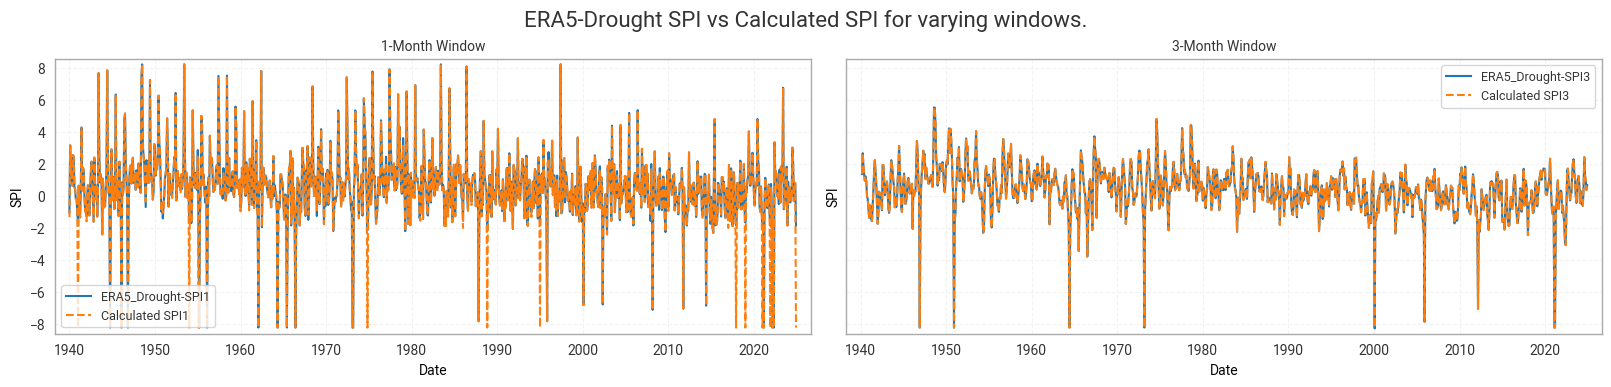

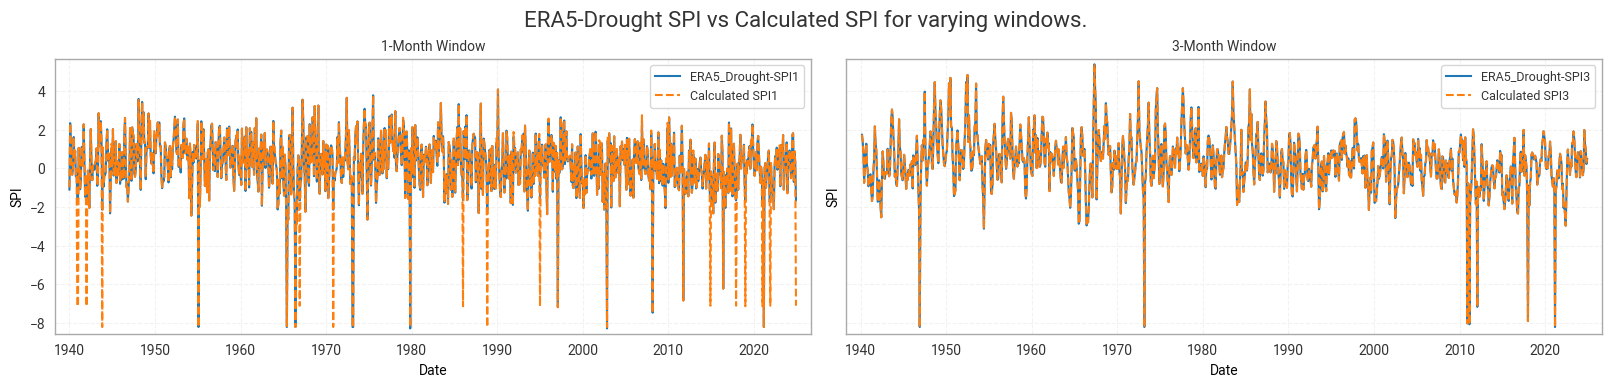

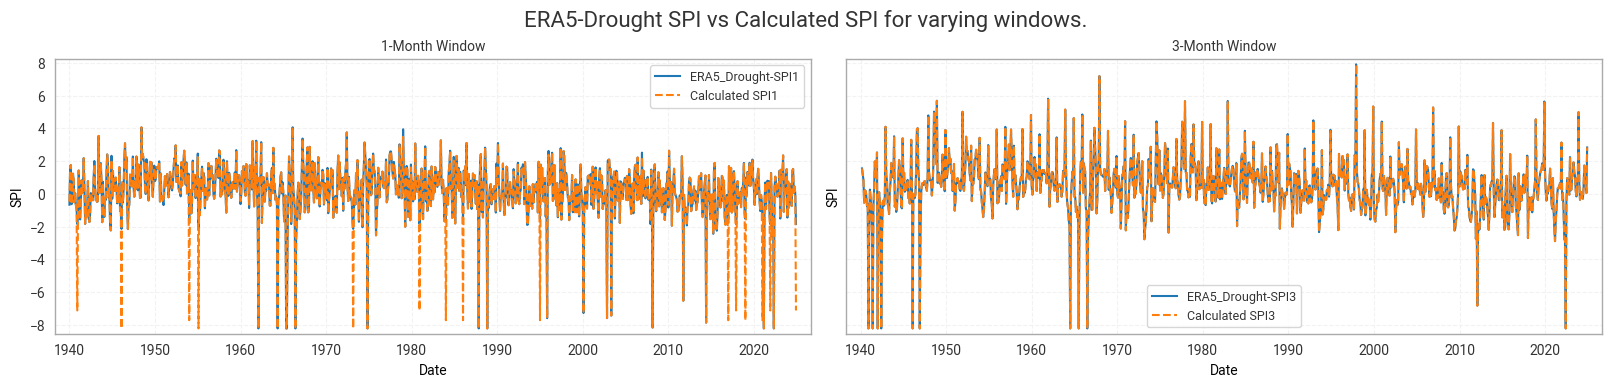

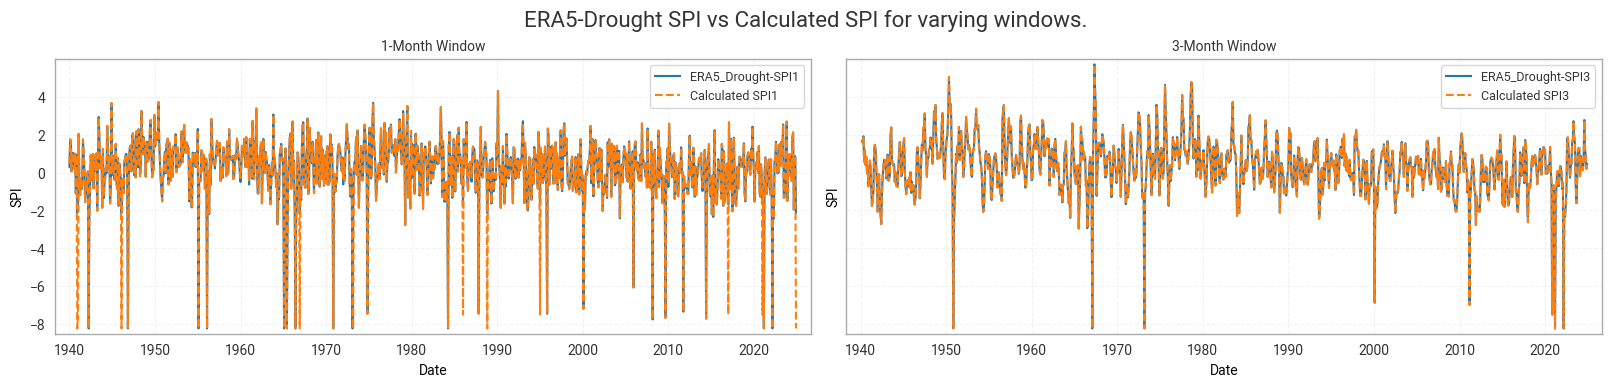

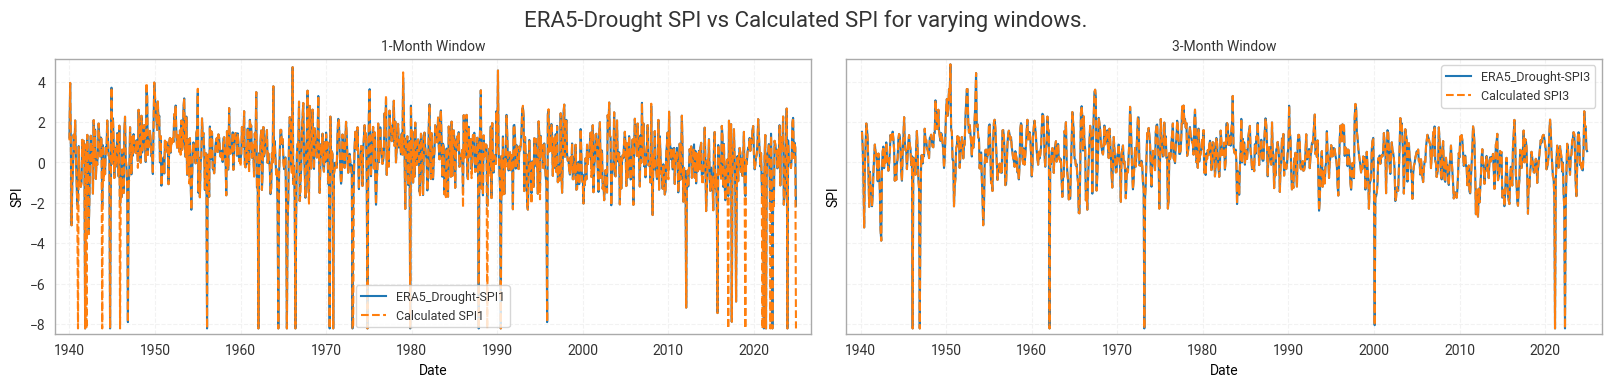

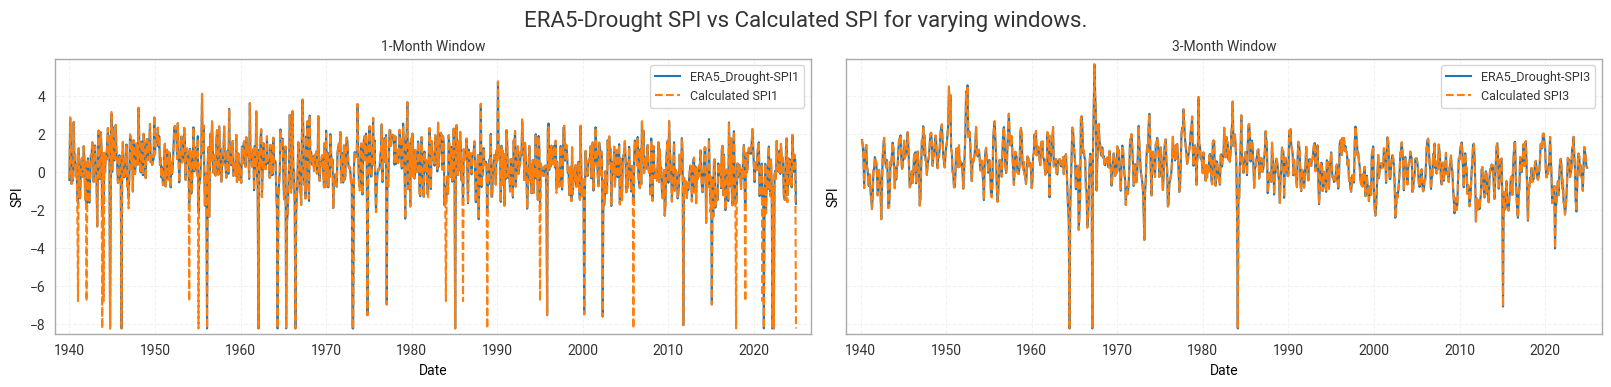

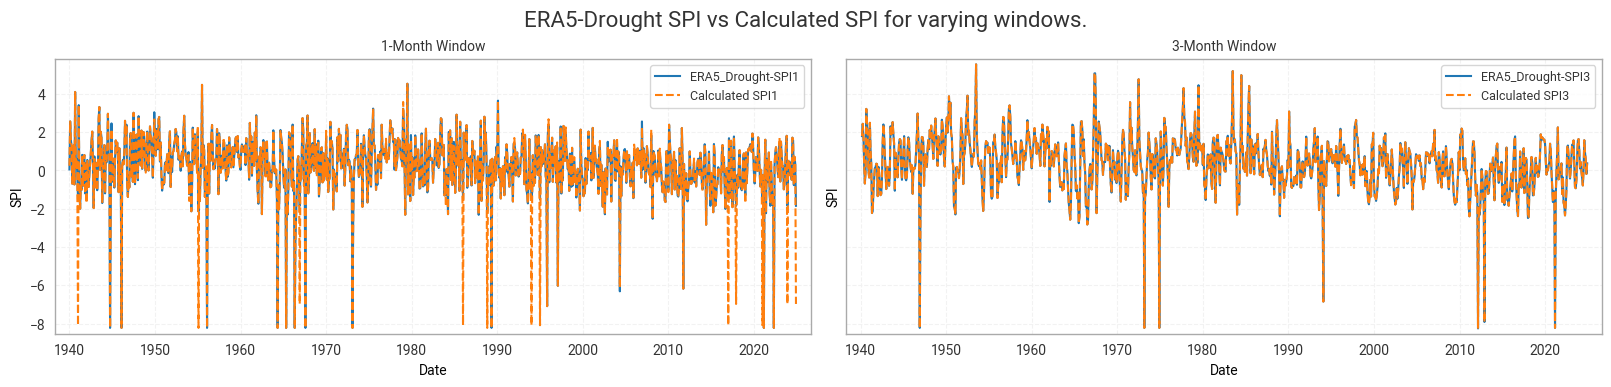

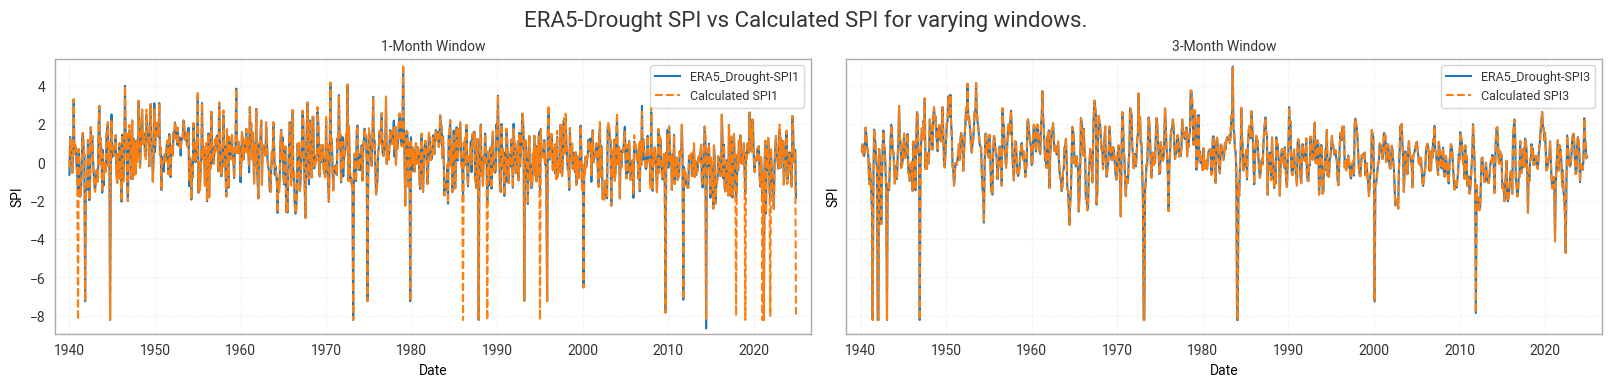

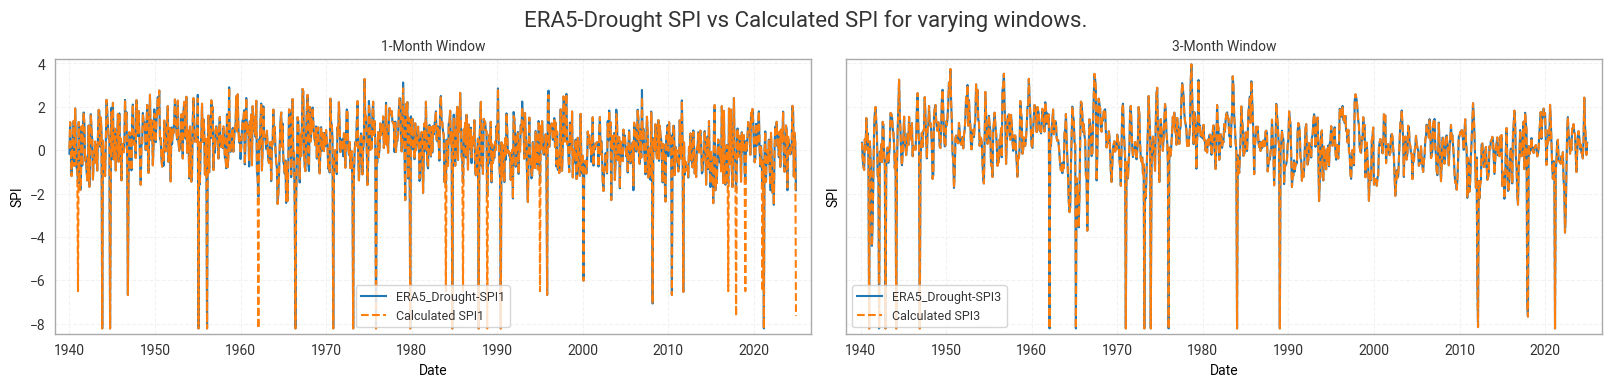

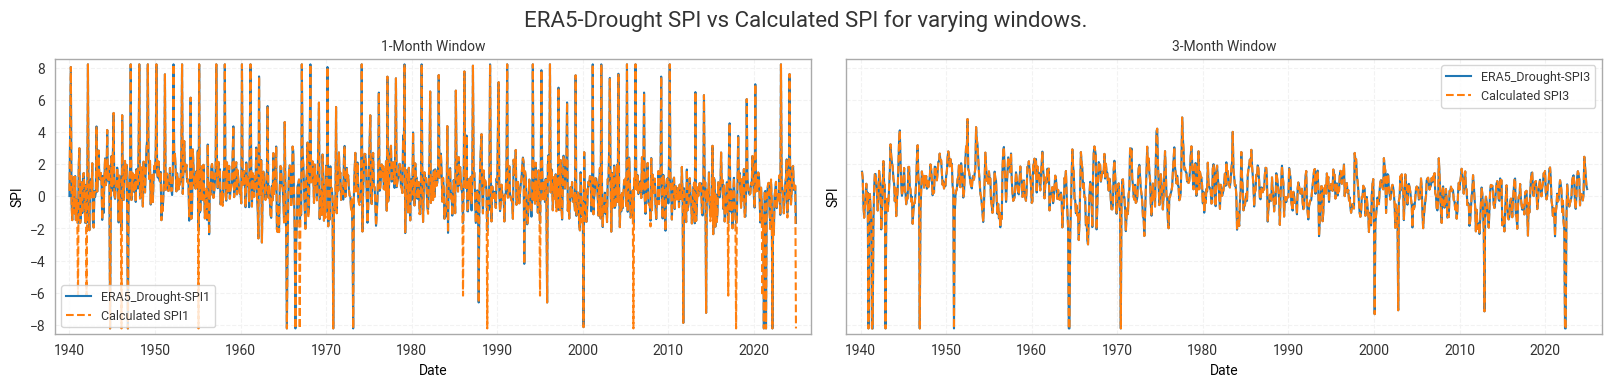

In [89]:
ACCUMULATION_PERIODS_focus = [1, 3]  # choose the periods you want

for m in range(0, 10):  #### patch this code so titles show which plot is which ensemble member. is obvious but for full thing?
    plot_qual_index_comparison("SPI", era5_spi_ens.sel(number=m), spi_ens_ds.sel(number=m), [1, 3])

#### Reading in ensemble SPEI

In [ ]:
era5_spei_ens = era5_drought_index_multiple("SPEI", accum_period = [3,24, 48])
era5_spei_ens = era5_spei_ens.sel(lat = 9.25, lon = 40.5) ### data needs to be downloaded overnight, couldn't do it.

2026-01-15 17:42:03,459 WARNING [2025-10-30T00:00:00] Downloading data from this dataset requires that the user be registered with the CDS. The use of the API requires a CDS API key.
2026-01-15 17:42:03,460 INFO Request ID is 26773b12-d24c-478b-9dbe-f49f0e66ca68
2026-01-15 17:42:03,536 INFO status has been updated to accepted
2026-01-15 17:42:12,021 INFO status has been updated to running


**Feedback:** Was there meant to be more here?

**Feedback:** This notebook is extremely long (by necessity) so it would be good to end on a recap with general conclusions.
For example, can you quantify the differences and tell me if those are a big deal in a general use case? As a user, I might not want to look at every panel in every figure, I just want to get a summary statistic and a general point.

## ℹ️ If you want to know more

### Key resources
The CDS catalogue entries for the data used were:
* Complete ERA5 global atmospheric reanalysis: [reanalysis-era5-complete](https://doi.org/10.24381/cds.143582cf)
* Monthly drought indices from 1940 to present derived from ERA5 reanalysis: [derived-drought-historical-monthly](https://doi.org/10.24381/9bea5e16)

Code libraries used:
* [earthkit](https://github.com/ecmwf/earthkit)
  * [earthkit-data](https://github.com/ecmwf/earthkit-data)
  * [earthkit-plots](https://github.com/ecmwf/earthkit-plots)

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.